In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import entropy, variation
import random

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins, nbrh_WG_open, mid_cum_Z4_sec
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
dico_garden_opening_hour = config.dico_garden_opening_hour
id_run = config.id_run
mindur_toaccountforZ4 = config.mindur_toaccountforZ4
dico_matching = config.dico_matching
print(id_run)

change the configuration file if not done yet!
ALLDATA_


# Download data

In [4]:
#cleaned mvt data
df_init = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date']) 
print(df_init.shape)
df_init.head(3)

(2681720, 18)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,duration,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,duration_mn,is_day
0,hen_1,pen9,8 - 9,2_Zone,1.0,2020-09-29 09:50:00,2020-09-29,2020-09-29 17:56:25,0 days 08:06:25,NaN,NaN,3_Zone,NaN,NaN,False,False,486.416667,True
1,hen_1,pen9,8 - 9,3_Zone,1.0,2020-09-29 17:56:25,2020-09-29,2020-09-30 09:55:59,0 days 02:52:35,2020-09-29 09:50:00,0 days 08:06:25,3_Zone,2_Zone,NaN,False,False,959.566667,False
2,hen_1,pen9,8 - 9,5_Zone,1.0,2020-09-30 09:55:59,2020-09-30,2020-09-30 11:34:30,0 days 01:32:11,2020-09-30 09:51:57,0 days 00:04:02,5_Zone,3_Zone,3_Zone,False,False,98.516667,True


In [10]:
#daily var
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
df_daily = df_daily[df_daily['level']!=dt.datetime(2021,7,25)]
print(df_daily.shape)
df_daily.head(3)

(39382, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,5_Zone,54000.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,3_Zone,5363.0,1.0,1.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,5_Zone,54000.0,0.0,0.0,9,True,126,18,8,2


#daily var IN BETWEEN CHECKS
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily__pen8TEST_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
print(df_daily.shape)
df_daily.head(3)

In [11]:
print(df_daily[df_daily['vertical_travel_distance_dawn']==0].shape)
print(df_daily[df_daily['vertical_travel_distance_dawn']>0].shape)

(33231, 70)
(300, 70)


In [12]:
df_daily[['list_ZALL','mid_cum_Z4_sec','list_of_zones','list_of_durations']]

,list_ZALL,mid_cum_Z4_sec,list_of_zones,list_of_durations
0,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",NaN,['5_Zone'],[32400.0]
1,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",1474.0,"['5_Zone', '3_Zone', '4_Zone', '5_Zone']","[532.0, 780.0, 325.0, 30763.0]"
2,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",520.0,"['3_Zone', '2_Zone', '3_Zone', '4_Zone', '5_Zo...","[225.0, 206.0, 24.0, 130.0, 31815.0]"
3,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,"['3_Zone', '2_Zone', '3_Zone', '2_Zone', '3_Zo...","[1059.0, 13499.0, 1854.0, 9057.0, 1502.0, 1829.0]"
4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,"['2_Zone', '3_Zone', '2_Zone', '3_Zone', '5_Zo...","[4325.0, 2707.0, 7088.0, 1977.0, 3930.0, 7170...."
...,...,...,...,...
39377,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",15088.0,"['4_Zone', '3_Zone', '4_Zone', '3_Zone', '2_Zo...","[676.0, 45.0, 9.0, 4.0, 1088.0, 31.0, 107.0, 5..."
39378,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",13686.0,"['3_Zone', '4_Zone', '3_Zone', '2_Zone', '3_Zo...","[719.0, 129.0, 69.0, 1056.0, 201.0, 27.0, 590...."
39379,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",13768.0,"['4_Zone', '3_Zone', '4_Zone', '3_Zone', '2_Zo...","[746.0, 26.0, 46.0, 83.0, 1054.0, 268.0, 735.0..."
39380,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",13599.0,"['4_Zone', '3_Zone', '2_Zone', '3_Zone', '2_Zo...","[730.0, 184.0, 1089.0, 182.0, 399.0, 78.0, 156..."


In [13]:
print(list(df_daily.columns))

['HenID', 'level', 'duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone', 'verification_daily_total_duration', 'verification_daily_total_nbr_hour', 'dur_values', 'dur_values_normalized', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec', 'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen', 'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone', 'list_of_durations', 'food_related_behavior', 'food_related_behavior_rp', 'food_related_behavior_rm', 'food_related_behavior4', 'food_related_behavior_rp4', 'food_related_behavior_rm4', 'nestboxes_related_behavior', 'list_of_zones', 'list_ZALL', 'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays', 'distribution_entropy', 'vertical_travel_d

# Transformation - Could be added in UTILS if another run

In [24]:
#add tracking system ID
df_daily['TrackingSystemID'] = df_daily['PenID'].map(lambda x: config.dico_pen_ts[x])
display(df_daily['TrackingSystemID'].value_counts())

TrackingSystem 10-12    14847
TrackingSystem 3-5      14764
TrackingSystem 8-9       9771
Name: TrackingSystemID, dtype: int64

In [25]:
#add if animal is not sleeping uppest
df_daily.loc[df_daily['night_Max_duration_zones'].isnull(),'night_Max_duration_zones'] = ''
df_daily['SleepingHeight'] = df_daily['night_Max_duration_zones'].map(lambda x: int(x.split('_')[0])-2 if x!='' else np.nan)#-2: litter (zon2: equal to 0 tiers underneath)
print(df_daily[df_daily['SleepingHeight'].isnull()].shape)
display(df_daily['SleepingHeight'].value_counts(normalize=True))
df_daily['Sleeping_NotUppest'] = df_daily['SleepingHeight'].map(lambda x: int(x!=3))
display(df_daily['Sleeping_NotUppest'].value_counts(normalize=True))

(450, 89)


3.0    0.696599
1.0    0.164286
2.0    0.135133
0.0    0.003981
Name: SleepingHeight, dtype: float64

0    0.688639
1    0.311361
Name: Sleeping_NotUppest, dtype: float64

In [26]:
df_daily[df_daily['SleepingHeight'].isnull()].shape

(450, 90)

### add vertical distance full light and /inside hour

In [22]:
df_daily['vertical_travel_distance_fulllight'] = df_daily.apply(lambda x: x['vertical_travel_distance']-x['vertical_travel_distance_dusk'], axis=1)
#we substract the dusk timing:
li_light_dusk_ = config.li_light_dusk_
nbr_dusk_sec = (max(li_light_dusk_)-min(li_light_dusk_)).seconds
print('dusk phase lasted for %d minutes' %(nbr_dusk_sec/60))
df_daily['vertical_travel_distance_fulllight_perinsideh'] = df_daily.apply(lambda x: x['vertical_travel_distance_fulllight']/(15-(x['duration_1_Zone']+nbr_dusk_sec)/60/60),axis=1)

dusk phase lasted for 13 minutes


### add food var

In [14]:
tupleFR_h_mn = [(6,1),(9,1),(12,1),(14,16)]
dico_nbr_liFAKEdate = config.dico_nbr_liFAKEdate
dico_nbr_liFAKEdate[1] = list(pd.date_range(start=dt.datetime(2020,1,1,4,55,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,5,40,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[1].extend(pd.date_range(start=dt.datetime(2020,1,1,6,20,0), 
                                  end=dt.datetime(2020,1,1,7,5,0), 
                                  freq = 'S'))

dico_nbr_liFAKEdate[2] = list(pd.date_range(start=dt.datetime(2020,1,1,7,55,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,8,40,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[2].extend(pd.date_range(start=dt.datetime(2020,1,1,9,20,0), 
                                  end=dt.datetime(2020,1,1,10,5,0), 
                                  freq = 'S'))

dico_nbr_liFAKEdate[3] = list(pd.date_range(start=dt.datetime(2020,1,1,10,55,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,11,40,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[3].extend(pd.date_range(start=dt.datetime(2020,1,1,12,20,0), 
                                  end=dt.datetime(2020,1,1,13,5,0), 
                                  freq = 'S'))      

dico_nbr_liFAKEdate[4] = list(pd.date_range(start=dt.datetime(2020,1,1,13,10,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,13,55,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[4].extend(pd.date_range(start=dt.datetime(2020,1,1,14,35,0), 
                                  end=dt.datetime(2020,1,1,15,20,0), 
                                  freq = 'S'))    

In [28]:
def food_SameDurationProperties(li_Z, config, dico_nbr_liFAKEdate, tupleFR_h_mn,
                                Nbr_random, fake_sec=0, sec_add_2fake=0, onlydurnottiming=False):
    
    #put into good format and check the lenght correspond to what is expectedd (2h-16h59)
    #from 1_zone to 1
    if len(li_Z)!=15*60*60:
        return (np.nan, np.nan,np.nan, np.nan)
    
    #initialise known parameters from configuraiton file
    dur_FR_beforeandafter_mn = config.dur_FR_beforeandafter_mn
   
    #initialise output values
    tFZ_ALL = 0
    tFZ_ALL_FAKE = 0
    
    if onlydurnottiming:
        li_choices = []
        for v in config.dico_nbr_liFAKEdate.values():
            li_choices.extend(v)
    
    #intialise the number of batch we will consider for that day-hen
    nbr_batch_considered = 0
    #initialise a dico with a list of zone where the hen was for each time the food was delivered
    dico_nbr_liz = {}
    for nbr,(h,mn) in enumerate(tupleFR_h_mn):
        
        #extract a list of the zone where the hen was during that batch of food delivery
        li_ = li_Z[((h-2)*60*60+mn*60-dur_FR_beforeandafter_mn*60)+fake_sec:((h-2)*60*60+mn*60+dur_FR_beforeandafter_mn*60)+fake_sec]
        dico_nbr_liz[nbr] = li_
        if len(li_)!=4*60:
            print(len(li_))
            print('ERROR ELSE DELETE THIS HERE')
            sys.exit()
        
        #compute time in a food zone vs time in a non food zone
        tFZ = sum([(v==3)|(v==5) for v in li_])
        tFZINSIDE = sum([(v!=1) for v in li_])
            
        #then, for each moment of food delivery, and for each instance where the hen was inside the whole time during food 
        #delivery, take a surrounding random moment, without accounting the 20mn before or after that moment, and chose a 
        #random time (but that does not include WG, just as the food timing batch time)
        if tFZINSIDE==4*60:
            #consider that batch to normalize with
            nbr_batch_considered = nbr_batch_considered + 1
            tFZ_ALL = tFZ_ALL + tFZ
            #without replacement, choose Nbr_random element from the list
            li_todo = random.sample(dico_nbr_liFAKEdate[nbr+1], Nbr_random*3) #*3 as the hen should be outside
            if onlydurnottiming:
                li_todo = random.sample(li_choices, Nbr_random*3)
            #for each fake starting time, compute the duration in food zone and output the mean
            li_tFZ_fake = []
            k = 0
            while k < Nbr_random:
                for faketime in li_todo:
                    h_ = faketime.hour
                    mn_ = faketime.minute
                    sec_ = faketime.second
                    li_fakezone = li_Z[((h_-2)*60*60+mn_*60+sec_+sec_add_2fake):((h_-2)*60*60+mn_*60+sec_+dur_FR_beforeandafter_mn*60*2+sec_add_2fake)]
                    if len(li_fakezone)!=4*60:
                        print(len(li_fakezone), h_, mn_, sec_)
                        print('ERROR ELSE DELETE THIS HERE')
                        sys.exit()
                    #if never went outside then keep it
                    tFZINSIDE_fake = sum([(v!=1) for v in li_])
                    if tFZINSIDE_fake==4*60:
                        #compute time in a food zone vs time in a non food zone
                        tFZ_fake = sum([(v==3)|(v==5) for v in li_fakezone])
                        li_tFZ_fake.append(tFZ_fake)
                        k = k +1
            #add the duration in foodzone based on random timing to the list for all the food-batches
            tFZ_ALL_FAKE = tFZ_ALL_FAKE + np.mean(li_tFZ_fake)
            
    return (tFZ_ALL/(nbr_batch_considered*4*60) - tFZ_ALL_FAKE/(nbr_batch_considered*4*60), tFZ_ALL, tFZ_ALL_FAKE, 
            nbr_batch_considered)

,HenID,level,food_sameDurTiming_r50_nbrbatch,food_sameDurTiming_r50,food_sameDurTiming_nbrbatch
0,hen_130,2020-10-05,"(nan, nan, nan, nan)",NaN,NaN
1,hen_130,2020-10-06,"(nan, nan, nan, nan)",NaN,NaN
2,hen_130,2020-10-07,"(nan, nan, nan, nan)",NaN,NaN


,HenID,level,food_sameDurTiming_r50_nbrbatch,food_sameDurTiming_r50,food_sameDurTiming_nbrbatch
39379,hen_98,2021-07-22,"(0.06808333333333333, 305, 255.98, 3)",0.068083,3.0
39380,hen_98,2021-07-23,"(0.03087037037037038, 240, 217.7733333333333, 3)",0.030870,3.0
39381,hen_98,2021-07-24,"(-0.3548611111111111, 0, 85.16666666666667, 1)",-0.354861,1.0


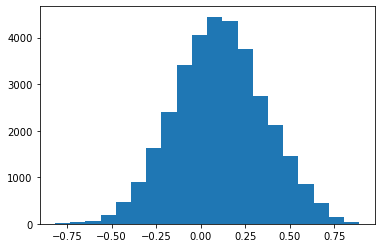

In [19]:
### same duration and timing properties (with random samples)
df_daily['food_sameDurTiming_r50_nbrbatch'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
df_daily['food_sameDurTiming_r50'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[2])
df_daily['food_sameDurTiming_nbrbatch'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[3])
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch','food_sameDurTiming_r50','food_sameDurTiming_nbrbatch']].head(3))
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch','food_sameDurTiming_r50','food_sameDurTiming_nbrbatch']].tail(3))
plt.hist(df_daily['food_sameDurTiming_r50'], bins=20)
plt.show()

,HenID,level,food_sameDurTiming_r50_nbrbatch_AP,food_sameDurTiming_r50_AP,food_sameDurTiming_nbrbatch_AP
0,hen_130,2020-10-05,"(nan, nan, nan, nan)",NaN,NaN
1,hen_130,2020-10-06,"(nan, nan, nan, nan)",NaN,NaN
2,hen_130,2020-10-07,"(nan, nan, nan, nan)",NaN,NaN


,HenID,level,food_sameDurTiming_r50_nbrbatch_AP,food_sameDurTiming_r50_AP,food_sameDurTiming_nbrbatch_AP
39379,hen_98,2021-07-22,"(0.023319444444444448, 240, 228.80666666666667...",0.023319,2.0
39380,hen_98,2021-07-23,"(0.2240833333333333, 217, 163.22, 1)",0.224083,1.0
39381,hen_98,2021-07-24,"(0.12141666666666664, 349, 232.44, 4)",0.121417,4.0


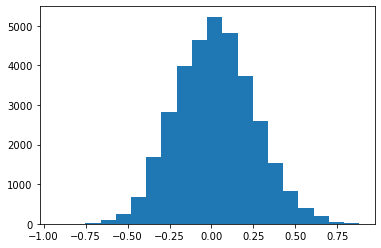

In [20]:
fake_sec_ = 20*60
df_daily['food_sameDurTiming_r50_nbrbatch_AP'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
df_daily['food_sameDurTiming_r50_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[2])
df_daily['food_sameDurTiming_nbrbatch_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[3])
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AP','food_sameDurTiming_r50_AP','food_sameDurTiming_nbrbatch_AP']].head(3))
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AP','food_sameDurTiming_r50_AP','food_sameDurTiming_nbrbatch_AP']].tail(3))
plt.hist(df_daily['food_sameDurTiming_r50_AP'], bins=20)
plt.show()

,HenID,level,food_sameDurTiming_r50_nbrbatch_AB,food_sameDurTiming_r50_AB,food_sameDurTiming_nbrbatch_AB
0,hen_130,2020-10-05,"(nan, nan, nan, nan)",NaN,NaN
1,hen_130,2020-10-06,"(nan, nan, nan, nan)",NaN,NaN
2,hen_130,2020-10-07,"(nan, nan, nan, nan)",NaN,NaN


,HenID,level,food_sameDurTiming_r50_nbrbatch_AB,food_sameDurTiming_r50_AB,food_sameDurTiming_nbrbatch_AB
39379,hen_98,2021-07-22,"(0.0841944444444444, 240, 199.58666666666667, 2)",0.084194,2.0
39380,hen_98,2021-07-23,"(-0.31174074074074076, 0, 224.45333333333335, 3)",-0.311741,3.0
39381,hen_98,2021-07-24,"(-0.12116666666666667, 97, 184.24, 3)",-0.121167,3.0


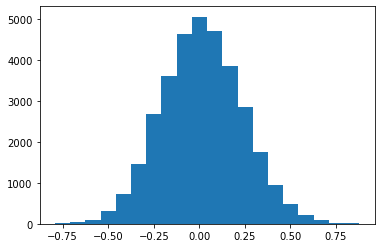

In [21]:
fake_sec_ = -20*60
df_daily['food_sameDurTiming_r50_nbrbatch_AB'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
df_daily['food_sameDurTiming_r50_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[2])
df_daily['food_sameDurTiming_nbrbatch_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[3])
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AB','food_sameDurTiming_r50_AB','food_sameDurTiming_nbrbatch_AB']].head(3))
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AB','food_sameDurTiming_r50_AB','food_sameDurTiming_nbrbatch_AB']].tail(3))
plt.hist(df_daily['food_sameDurTiming_r50_AB'], bins=20)
plt.show()

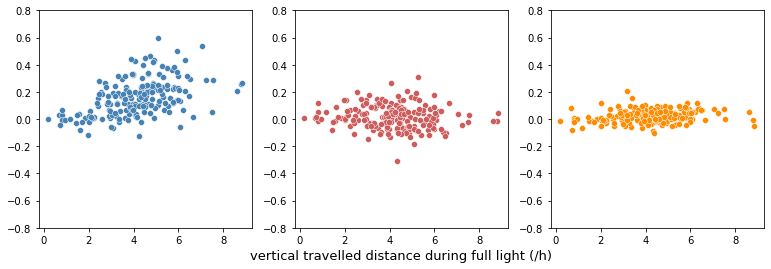

In [23]:
df_BS = df_daily[df_daily['level']<=dt.datetime(2021,3,27)].copy()
pal_ = {'food_sameDurTiming_r50_AB':'darkorange',
        'food_sameDurTiming_r50_AP':'indianred',
        'food_sameDurTiming_r50':'steelblue'}
l=1
c=3
fig = plt.figure(figsize=(13,4)) #/100 si trop grand nbr
df_plt = df_BS.groupby(['HenID']).mean().reset_index()
plt.subplot(l,c,1)
#plt.figure(figsize=(5,4))
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50',
                color=pal_['food_sameDurTiming_r50'])#,  size="size", sizes=(20, 200))
plt.xlabel('')
plt.ylabel('')
#plt.title('food reactivity index')
plt.yticks(fontsize=10)
plt.ylim((-0.8, 0.8))

#plt.figure(figsize=(5,4))
plt.subplot(l,c,2)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50_AP',
                color=pal_['food_sameDurTiming_r50_AP'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('hens\' mean value')
plt.xlabel('vertical travelled distance during full light (/h)', size=13)
plt.ylim((-0.8, 0.8))

#plt.figure(figsize=(5,4))
plt.subplot(l,c,3)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50_AB',
                color=pal_['food_sameDurTiming_r50_AB'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('food reactivity index backward push')
plt.xlabel('')
plt.ylim((-0.8, 0.8))
#plt.savefig(os.path.join(path_extracted_data,'dfBS_Raw_VTD_food.png'),dpi=300,format='png',bbox_inches='tight')
plt.show();

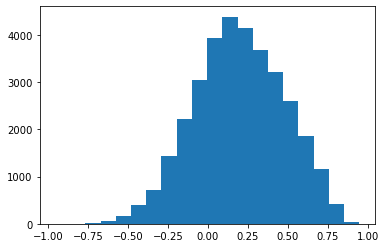

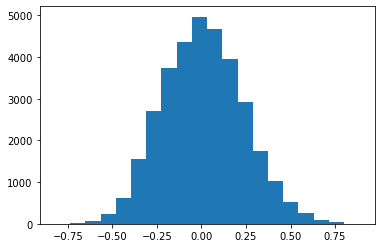

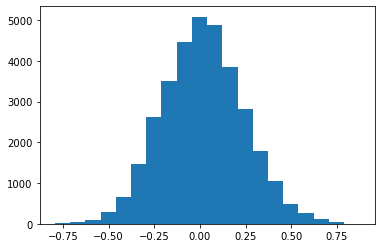

In [29]:
### same duration and timing properties (with random samples)
fake_sec_ = 4*60
df_daily['food_sameDurTiming_r50_nbrbatch_4mn'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50,sec_add_2fake=4*60,fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
df_daily['food_sameDurTiming_r50_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_4mn'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_4mn'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_4mn'].map(lambda x: x[2])
df_daily['food_sameDurTiming_nbrbatch_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_4mn'].map(lambda x: x[3])
plt.hist(df_daily['food_sameDurTiming_r50_4mn'], bins=20)
plt.show()


fake_sec_ = 20*60 + 4*60
df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, sec_add_2fake=4*60, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
df_daily['food_sameDurTiming_r50_AP_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_AP_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AP_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'].map(lambda x: x[2])
df_daily['food_sameDurTiming_nbrbatch_AP_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'].map(lambda x: x[3])
plt.hist(df_daily['food_sameDurTiming_r50_AP_4mn'], bins=20)
plt.show()

fake_sec_ = -20*60 + 4*60
df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, sec_add_2fake=4*60, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
df_daily['food_sameDurTiming_r50_AB_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_AB_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AB_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'].map(lambda x: x[2])
df_daily['food_sameDurTiming_nbrbatch_AB_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'].map(lambda x: x[3])
plt.hist(df_daily['food_sameDurTiming_r50_AB_4mn'], bins=20)
plt.show()

### add nestbox zone var

#nbr transitions per hour. 
#df_daily['nbr_h_WGopen'] = df_daily['level'].map(lambda x: nbrh_WG_open(x, config))
li_ = ['vertical_travel_distance','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
for v in li_:
    df_daily[v+'_perh'] = df_daily.apply(lambda x: x[v]/x['nbr_h_per_day'], axis=1)
    df_daily['nbr_stays_1_Zone_perh'] = df_daily.apply(lambda x: x['nbr_stays_1_Zone']/x['nbr_h_WGopen'] if x['nbr_h_WGopen']!=0 else np.nan, axis=1)
df_daily[['vertical_travel_distance_perh','vertical_travel_distance', 'nbr_stays_3_Zone', 'nbr_stays_3_Zone_perh',
        'nbr_h_per_day']].tail(3)

#uncommon/extreme behavior
df_daily['uncommon_behavior'] = df_daily.apply(lambda x: sum([x['Total_number_zone']<=2])>=1, axis=1)
display(df_daily[df_daily['level']>dt.datetime(2020,11,10)]['uncommon_behavior'].value_counts(normalize=True))
df_daily[(df_daily['uncommon_behavior']>0)&(df_daily['level']>dt.datetime(2020,11,10))][['level','HenID','uncommon_behavior','SleepingHeight','nestboxes_related_behavior',
                                           'Total_number_zone']].head(5)

#uncommon/extreme behavior
df_daily['uncommon_behavior'] = df_daily.apply(lambda x: sum([x['SleepingHeight'] in [0,1], 
                                                              x['nestboxes_related_behavior']<0,
                                                              x['Total_number_zone']<=2,
                                                              x['duration_4_Zone']<15*60])>=1, axis=1)
display(df_daily[df_daily['level']>dt.datetime(2020,11,10)]['uncommon_behavior'].value_counts(normalize=True))
df_daily[(df_daily['uncommon_behavior']>0)&(df_daily['level']>dt.datetime(2020,11,10))][['level','HenID','uncommon_behavior','SleepingHeight','nestboxes_related_behavior',
                                           'Total_number_zone']].head(5)

#only since 2h start in the morning. ALL DAY! we want mid tiem ONLY MORNING!
df_daily['time_midduratioZ4_h'] = df_daily['mid_cum_Z4_sec'].map(lambda x: x/60/60+2)
df_daily.loc[df_daily['level']<dt.datetime(2020,11,13,0,0,0),'time_midduratioZ4_h'] = np.nan
plt.hist(df_daily['time_midduratioZ4_h']);
df_daily[['list_Z4', 'mid_cum_Z4_sec','nbr_h_per_day','time_midduratioZ4_h']].head(3)

df_daily['nbr_visit_Z4_Morning_more60sec'] = df_daily['list_ZALL'].map(lambda x: nbr_early_visit_Z4_moreXsec(eval(x)[0:((8-2)*60*60)],
                                                                                                           60))
plt.hist(df_daily[(df_daily['level']>dt.datetime(2020,11,13))]['nbr_visit_Z4_Morning_more60sec']);

df_daily['nbr_visit_Z4_Morning'] = df_daily['list_ZALL'].map(lambda x: nbr_early_visit_Z4(eval(x)[0:((8-2)*60*60)]))
plt.hist(df_daily['nbr_visit_Z4_Morning']);

df_daily['duration_until8_inZ4'] = df_daily['list_ZALL'].map(lambda x: sum(list_Z4(eval(x))[0:((8-2)*60*60)]))

df_daily['nbr_visit_Z4_Morning_more'+str(mindur_toaccountforZ4)+'sec'] = df_daily['list_ZALL'].map(lambda x: nbr_early_visit_Z4_moreXsec(eval(x)[0:((8-2)*60*60)],
                                                                                                           mindur_toaccountforZ4))
plt.hist(df_daily['nbr_visit_Z4_Morning_more'+str(mindur_toaccountforZ4)+'sec']);

In [30]:
len(eval(df_daily['list_ZALL'].iloc[1]))/60/60

9.0

In [31]:
len(eval(df_daily['list_ZALL'].iloc[1])[0:((8-2)*60*60)])/60/60

6.0

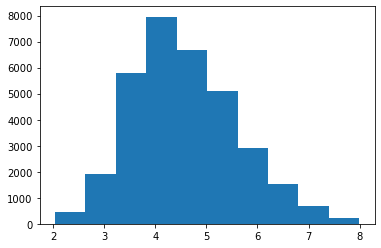

In [32]:
#mid-time Z4 ONLY MORNING
df_daily['mid_cum_Z4_sec_Morning'] = df_daily['list_ZALL'].map(lambda x: mid_cum_Z4_sec(eval(x)[0:((8-2)*60*60)]))
#nan during the days where the artificial light does not start at 2h!
df_daily.loc[df_daily['level']<dt.datetime(2020,11,13,0,0,0),'mid_cum_Z4_sec_Morning'] = np.nan
df_daily['mid_cum_Z4_h_Morning'] = df_daily['mid_cum_Z4_sec_Morning'].map(lambda x: x/60/60+2)
plt.hist(df_daily[(df_daily['level']>dt.datetime(2020,11,13))]['mid_cum_Z4_h_Morning']);

df_plt = df_daily.groupby(['HenID'])[['nbr_visit_Z4_Morning_more60sec','mid_cum_Z4_h_Morning']].mean().reset_index()
print(df_plt.shape)
display(df_plt.head(3))
plt.scatter(df_plt['nbr_visit_Z4_Morning_more60sec'].tolist(), df_plt['mid_cum_Z4_h_Morning'].tolist());

df_daily[(df_daily['level']>dt.datetime(2020,11,13))&(df_daily['duration_until8_inZ4']<15*60)][['duration_until8_inZ4',
                                                                                                   'HenID','level',
                                                                                                   'mid_cum_Z4_h_Morning',
                                                                                               'nbr_visit_Z4_Morning_more60sec']]

### add order of going to the litter in the morning

#sorted so that smallest comes first
dico_level_sortedlistdate = dict(df_daily.groupby(['level','PenID'])['FirstTimestamp_2_Zone'].agg(lambda x: sorted([i for i in list(x) if i is not pd.NaT])))
df_daily['order_firstlitter'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['FirstTimestamp_2_Zone']) if x['FirstTimestamp_2_Zone'] is not pd.NaT else np.nan, axis=1)
df_daily['order_firstlitter_percent'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['FirstTimestamp_2_Zone'])/\
                                           len(dico_level_sortedlistdate[(x['level'],x['PenID'])]) if x['FirstTimestamp_2_Zone'] is not pd.NaT else np.nan, axis=1)

#small verification
df_daily[df_daily['PenID']==10][['order_firstlitter','order_firstlitter_percent','FirstTimestamp_2_Zone','level','PenID',
                                 'HenID']].sort_values(['FirstTimestamp_2_Zone'])

#verify that when an animal slept in the litter then its the first animal to be in litter.
#find such instance (i.e. the day after sleeping height=0!)
display(df_daily[(df_daily['SleepingHeight']==0)&(df_daily['PenID']==10)][['order_firstlitter','order_firstlitter_percent',
                                                                   'FirstTimestamp_2_Zone','level','PenID','HenID',
                                                                   'SleepingHeight']])
df_daily[(df_daily['level'].isin([dt.datetime(2020,10,6),dt.datetime(2020,10,16),dt.datetime(2020,10,22),
                                  dt.datetime(2020,10,28)]))&(df_daily['HenID']=='hen_143')][['order_firstlitter','order_firstlitter_percent',
                                                                   'FirstTimestamp_2_Zone','level','PenID','HenID',
                                                                   'SleepingHeight']]
#correct!

### add order of going to the top floor in the evening

#compute last timestamp:
#why: will be usefull to produce other variables, to verify the code and to use it for some zones
df_ = df_init[df_init['Zone']=='5_Zone'].groupby(['HenID', 'date'])['Timestamp'].agg(lambda x: max(list(x))).reset_index()
df_.rename(columns={'Timestamp':'LastTimestampToptier','date':'level'}, inplace=True)
display(df_)
df_daily = pd.merge(df_daily, df_, how='left', on=['HenID','level'])

#ATTENTION: LastTimestampToptier does not mean that the bird stayed there after!! so have to be combined with their sleeping height
#Note that if the hen arrived up at 16h59, but then was kikked away at 17h01: we dont care as long as its sleeping height is the top floor.
#sorted so that smallest comes first
dico_level_sortedlistdate = dict(df_daily.groupby(['level','PenID'])['LastTimestampToptier'].agg(lambda x: sorted([i for i in list(x) if i is not pd.NaT])))
df_daily['order_firstgoingup'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['LastTimestampToptier']) if x['LastTimestampToptier'] is not pd.NaT else np.nan, axis=1)
df_daily['order_firstgoingup_percent'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['LastTimestampToptier'])/\
                                           len(dico_level_sortedlistdate[(x['level'],x['PenID'])]) if x['LastTimestampToptier'] is not pd.NaT else np.nan, axis=1)
df_daily['LastTimestampToptier_time'] = df_daily['LastTimestampToptier'].map(lambda x: dt.datetime.time(x))
#small verification
df_daily[df_daily['PenID']==10][['order_firstgoingup','order_firstgoingup_percent','LastTimestampToptier','LastTimestampToptier_time',
                                 'level','PenID','HenID','SleepingHeight']].sort_values(['LastTimestampToptier'])
#ISSUE: might not be there anymore!!! should be done with ts!!!!! but then waht if an animal arrive when its dark? bold or not?

#would be 0 if they did not slept up, 1 would mean and 
#in that case, the bird that went up at 6h30 or the one that did not slept in top tier have the save value:30
df_daily['lastminutessleepingUP'] = df_daily.apply(lambda x: x['SleepingHeight']==3 & x['LastTimestampToptier'], axis=1)

#(day_Z5 /day – night_Z5/night) / (day_Z5 /day + night_Z5/night)
def Z5_diurnality(dur_day, dur_night, nbr_h_per_day):
    n = dur_day/nbr_h_per_day - dur_night/(24-nbr_h_per_day)
    p = dur_day/nbr_h_per_day + dur_night/(24-nbr_h_per_day)
    #if never spent time in Z5 then return: neutral nght versus day behavior
    if p==0:
        return 0
    return n/p  

df_daily['Z5diuranility'] = df_daily.apply(lambda x: Z5_diurnality(dur_day=x['duration_5_Zone'],
                                                                   dur_night=x['night_duration_Z5'],
                                                                   nbr_h_per_day=x['nbr_h_per_day']), axis=1)
plt.hist(df_daily['Z5diuranility']);
df_daily[['night_duration_Z5','duration_5_Zone','Z5diuranility']].tail(5)

#coefficient of variation: ratio of standard deviation to mean. np.std(x) / np.mean(x)
df_daily['CVduration'] = df_daily['list_of_durations'].map(lambda x: variation(eval(x)))
display(df_daily[df_daily['CVduration'].isnull()])
df_daily[['list_of_durations','list_of_zones','latency_1_Zone_h','latency_4_Zone_h','latency_2_Zone_h','CVduration']]
plt.hist(df_daily['CVduration']);

# Add daily HA using interpolation

In [33]:
#KBF&severity
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_HA['FeatherDamage'] = df_HA['Feathers'].map(lambda x: 100-x)
df_HA['date_HA'] = df_HA['date'].copy()
df_HA = df_HA[~df_HA['HenID'].isnull()] #two isntances
print(df_HA.shape)
#display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
display(df_HA['HAID'].value_counts())
#info on date
display(df_HA.groupby(['HAID','date','WOA','DOA'])['HenID'].count().reset_index())
print(df_HA.shape)
df_HA.head(3)

(844, 60)


HA3    176
HA4    176
HA1    175
HA2    160
HA5    157
Name: HAID, dtype: int64

,HAID,date,WOA,DOA,HenID
0,HA1,2020-11-23,25.0,173.0,175
1,HA2,2021-01-04,31.0,215.0,160
2,HA3,2021-02-01,35.0,243.0,176
3,HA4,2021-04-12,45.0,313.0,176
4,HA5,2021-07-25,60.0,417.0,157


(844, 60)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,backpack,FeatherDamage,date_HA
0,M,09:30,pen9,42grey,normal,25.0,NaN,0.0,0.0,0.0,...,109.0,0,0.0,42grey9sb,NaN,NaN,"['', '42', 'grey', '9', 'sb']",sb,NaN,2020-11-23
1,Mark,14:54,pen9,66grey,normal,0.0,NaN,50.0,0.0,0.0,...,509.0,16,0.0,66grey9sp,NaN,NaN,"['', '66', 'grey', '9', 'sp']",sp,14.0,2021-02-01
2,Camille,10:30,pen5,2green,normal,130.0,NaN,25.0,0.0,0.0,...,428.0,4,0.0,2green5pp,NaN,NaN,"['', '2', 'green', '5', 'pp']",pp,8.0,2021-02-01


In [34]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
print(df_FB.shape)
df_FB.head(3)

(232, 14)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [35]:
def inter_HA(HenID, DOA, df_HA, df_FB, str_ha):
    if str_ha not in df_HA.columns:
        print('error, specify an exist column name')
        sys.exit()
    #available HA days, for that specific hen
    li_DOA = np.array(df_HA[(df_HA['HenID']==HenID)&(~df_HA[str_ha].isnull())]['DOA'].unique())
    if len(li_DOA)==0:
        return np.nan
    mi = min(li_DOA)
    ma = max(li_DOA)
        
    #if its an exact date (never happen, except for last date, which we put to be the date previous the real HA)
    if DOA in li_DOA:
        return df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==DOA)][str_ha].iloc[0]
    
    #if its at the lower boundery, then add the timestamp 0 when they moved to the laying barn
    #(if its at the higher boundery, then add the KBF from that time (but this should never happend))
    #we wont allow a to big difference either
    #the day previous can be assumed as the same as the actual health measured ont eh day after
    if (DOA<mi) & (mi-DOA==1):
        x1 = 119
        wdoa119 = df_FB[df_FB['HenID']==HenID]['29-09 weight'].iloc[0]
        x2 = li_DOA[li_DOA > DOA].min() #smallest above 
        #we actually only allows this when the highiest above is HA 1, i.e. 173 DOA
        if x2==173:
            return(df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==mi)][str_ha].iloc[0])        

    if (DOA<mi) & (str_ha=='weight'):
        x1 = 119
        wdoa119 = df_FB[df_FB['HenID']==HenID]['29-09 weight'].iloc[0]
        x2 = li_DOA[li_DOA > DOA].min() #smallest above 
        #we actually only allows this when the highiest above is HA 1, i.e. 173 DOA
        if x2==173:
            return(np.interp(DOA, xp=(x1,x2), fp=(wdoa119, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))        
    if (DOA<mi) & (str_ha=='FeatherDamage'):
        fdoa119 = 0 #assume 0 for all when transfer to LB
        x1 = 119
        x2 = li_DOA[li_DOA > DOA].min() #smallest above
        #we actually only allows this when the highiest above is HA 1, i.e. 173 DOA
        if x2==173:
            return(np.interp(DOA, xp=(x1,x2), fp=(0, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))        
    if DOA<mi:
        #print(DOA)
        #x1 = df_daily[df_daily['DIB']==1]['DOA'].iloc[0] #119 doa
        #x2 = li_DOA[li_DOA > DOA].min() #smallest above 
        #return(np.interp(DOA, xp=(x1,x2), fp=(0, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))        
        return np.nan
        
    #if its at the higher boundery, then add the KBF from that time (can happen with for example early death)
    if DOA>ma:
        return(df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==ma)][str_ha].iloc[0])        

    #else:
    x1 = li_DOA[li_DOA < DOA].max() #largest below
    x2 = li_DOA[li_DOA > DOA].min() #smallest above 
    #print(x1,x2,DOA,HenID)
    return(np.interp(DOA, xp=(x1,x2), 
                     fp=(df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x1)][str_ha].iloc[0],
                         df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))
        
df_daily['KBF_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                           df_HA=df_HA, df_FB=df_FB, str_ha='severity'), axis=1)

print('FeatherDamage')
df_daily['FeatherDamage_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                              df_HA=df_HA, df_FB=df_FB, str_ha='FeatherDamage'), axis=1)
print('weight')
df_daily['weight_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                              df_HA=df_HA, df_FB=df_FB, str_ha='weight'), axis=1)

FeatherDamage
weight


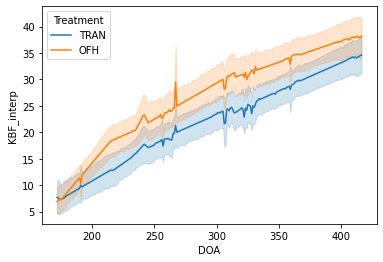

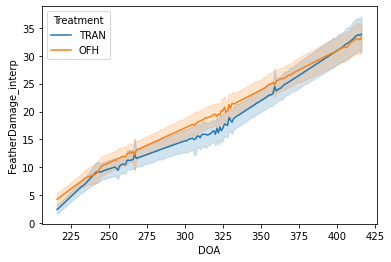

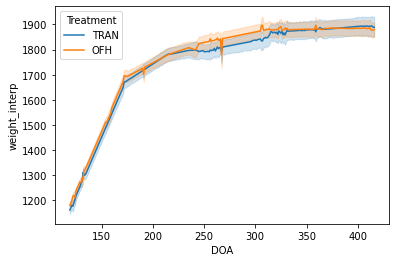

In [36]:
sns.lineplot(x='DOA', y='KBF_interp', hue='Treatment', data=df_daily);
plt.show()
sns.lineplot(x='DOA', y='FeatherDamage_interp',  hue='Treatment', data=df_daily);
plt.show()
sns.lineplot(x='DOA', y='weight_interp', hue='Treatment', data=df_daily);

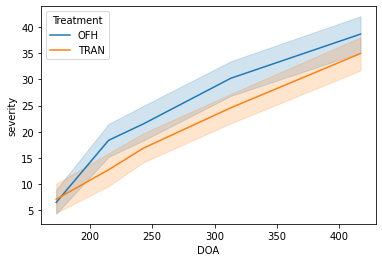

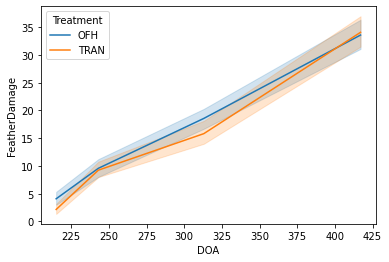

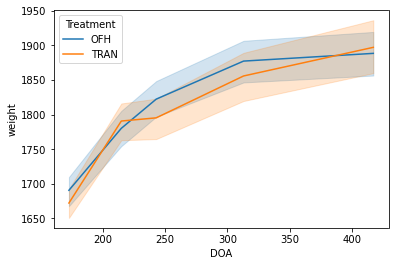

In [37]:
sns.lineplot(x='DOA', y='severity', hue='Treatment', data=df_HA);
plt.show()
sns.lineplot(x='DOA', y='FeatherDamage',  hue='Treatment', data=df_HA);
plt.show()
sns.lineplot(x='DOA', y='weight', hue='Treatment', data=df_HA);

# Add daily HA using BLUPS

In [38]:
df_initweight = df_FB[['HenID','29-09 weight']].copy()
df_initweight['DIB'] = 0
df_initweight = df_initweight.rename(columns={'29-09 weight':'weight'})
df_initweight['FeatherDamage'] = 0
df_initweight['severity'] = 0
display(df_initweight.head(3))
df_HA['DIB'] = df_HA['DOA'].map(lambda x: x-118)
df_hablups = df_HA[['HenID','DOA','DIB','severity','FeatherDamage','weight']].copy()
display(df_hablups.head(3))
print(df_initweight.shape, df_hablups.shape)
df_hablups = pd.concat([df_initweight, df_hablups])
print(df_hablups.shape)
display(df_hablups.head(3))
df_hablups = df_hablups[~df_hablups['DIB'].isnull()]
print(df_hablups.shape)
df_hablups.to_csv(os.path.join(path_extracted_data,'df_hablups_all.csv'), index=False, sep=',')
df_ = df_hablups.groupby(['HenID'])['weight'].count().reset_index()
li_hen = df_[df_['weight']>3]['HenID'].tolist()#with at least 3 observation (i.e. 2 as the first one does not really count for severity and feather)
df_hablups[df_hablups['HenID'].isin(li_hen)].to_csv(os.path.join(path_extracted_data,'df_hablups.csv'), index=False, sep=',')

,HenID,weight,DIB,FeatherDamage,severity
0,hen_1,1134.0,0,0,0
1,hen_10,1070.0,0,0,0
2,hen_100,1182.0,0,0,0


,HenID,DOA,DIB,severity,FeatherDamage,weight
0,hen_164,173.0,55.0,0,NaN,1673.8
1,hen_181,243.0,125.0,16,14.0,2206.9
2,hen_82,243.0,125.0,4,8.0,1790.9


(232, 5) (844, 6)
(1076, 6)


,HenID,weight,DIB,FeatherDamage,severity,DOA
0,hen_1,1134.0,0.0,0.0,0,NaN
1,hen_10,1070.0,0.0,0.0,0,NaN
2,hen_100,1182.0,0.0,0.0,0,NaN


(1076, 6)


# Adding (henID;WIB) serie

In [39]:
df_daily['HenID_WIB'] = df_daily.apply(lambda x: x['HenID']+'-WIB'+str(x['WIB']), axis=1)
df_daily[['HenID_WIB','HenID','WIB']].head(5)

,HenID_WIB,HenID,WIB
0,hen_130-WIB1,hen_130,1
1,hen_130-WIB1,hen_130,1
2,hen_130-WIB2,hen_130,2
3,hen_131-WIB1,hen_131,1
4,hen_131-WIB1,hen_131,1


# Correcting food reactivity index

### initial measure

In [40]:
#food_related_behavior should be replaced by food_related_behavior4 from the 28.03.2021 due to summer time changed that
#probably changed the computer programe timing too
df_daily['food_related_behavior_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior'], df_daily['food_related_behavior4'])
df_daily['food_related_behavior_rp_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior_rp'], df_daily['food_related_behavior_rp4'])
df_daily['food_related_behavior_rm_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior_rm'], df_daily['food_related_behavior_rm4'])

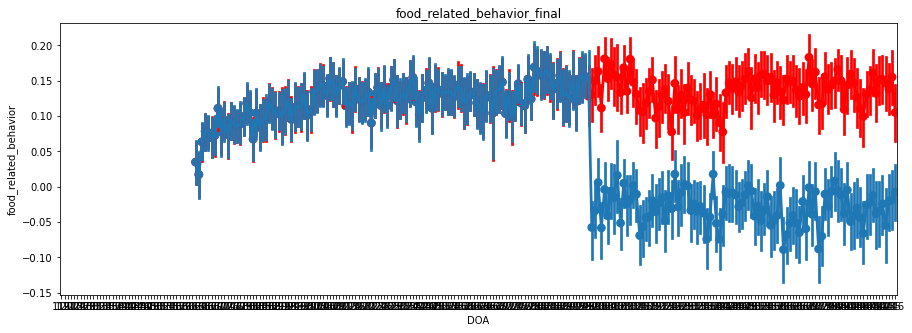

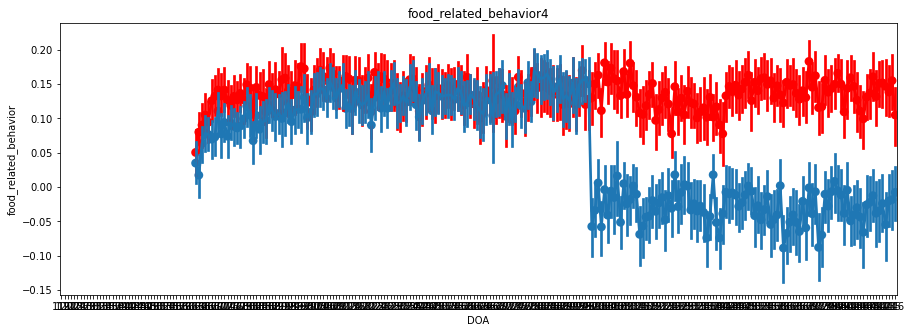

In [42]:
#small verification: CORRECT!
li_food = ['food_related_behavior_final','food_related_behavior4']
for b in li_food:
    plt.figure(figsize=(15,5))
    sns.pointplot(y=b, x='DOA', color='red', data=df_daily);
    sns.pointplot(y='food_related_behavior', x='DOA',  data=df_daily);
    plt.title(b)
    plt.show();

In [43]:
df_plt = pd.melt(df_daily[df_daily['level']>config.date_consistent_barn_schedule], id_vars=['HenID','WOA','level','PenID'], 
        value_vars=['food_related_behavior_final','food_related_behavior_rp_final','food_related_behavior_rm_final'],
        value_name='food_behavior')
df_plt['is_positive'] = df_plt['food_behavior'].map(lambda x: int(x>0))
display(df_plt.head(3))
#display(df_plt.groupby(['variable'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index())
df_plt_ = df_plt.groupby(['variable','level'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index()
display(df_plt_.head(3))
df_plt_.groupby(['variable']).agg(mean_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.nanmean(x)),
           sd_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.std(x))).reset_index()
#weekly average +-SD of the mean daily food-related behavior across individuals

,HenID,WOA,level,PenID,variable,food_behavior,is_positive
0,hen_131,24,2020-11-14,10,food_related_behavior_final,0.141396,1
1,hen_131,24,2020-11-15,10,food_related_behavior_final,0.156883,1
2,hen_131,24,2020-11-16,10,food_related_behavior_final,-0.225432,0


,variable,level,is_positive
0,food_related_behavior_final,2020-11-14,56.410256
1,food_related_behavior_final,2020-11-15,64.743590
2,food_related_behavior_final,2020-11-16,74.358974


,variable,mean_is_positive,sd_is_positive
0,food_related_behavior_final,76.382719,4.118489
1,food_related_behavior_rm_final,52.853390,6.527107
2,food_related_behavior_rp_final,53.776116,4.594645


In [44]:
df_plt[df_plt['food_behavior']==-1].groupby(['variable','HenID']).count().reset_index().sort_values(['WOA']).tail(20)

,variable,HenID,WOA,level,PenID,food_behavior,is_positive
184,food_related_behavior_rp_final,hen_59,8,8,8,8,8
131,food_related_behavior_rp_final,hen_151,8,8,8,8,8
71,food_related_behavior_rm_final,hen_225,8,8,8,8,8
32,food_related_behavior_rm_final,hen_115,8,8,8,8,8
103,food_related_behavior_rm_final,hen_85,9,9,9,9,9
58,food_related_behavior_rm_final,hen_191,10,10,10,10,10
133,food_related_behavior_rp_final,hen_164,11,11,11,11,11
108,food_related_behavior_rp_final,hen_10,11,11,11,11,11
8,food_related_behavior_final,hen_17,11,11,11,11,11
51,food_related_behavior_rm_final,hen_17,11,11,11,11,11


In [45]:
df_plt[(df_plt['food_behavior']==-1)&(df_plt['HenID']=='hen_173')]

,HenID,WOA,level,PenID,variable,food_behavior,is_positive
59957,hen_173,26,2020-11-29,8,food_related_behavior_rp_final,-1.0,0
59964,hen_173,27,2020-12-06,8,food_related_behavior_rp_final,-1.0,0
59970,hen_173,28,2020-12-12,8,food_related_behavior_rp_final,-1.0,0
59971,hen_173,28,2020-12-13,8,food_related_behavior_rp_final,-1.0,0
59983,hen_173,30,2020-12-26,8,food_related_behavior_rp_final,-1.0,0
...,...,...,...,...,...,...,...
93519,hen_173,58,2021-07-11,8,food_related_behavior_rm_final,-1.0,0
93521,hen_173,58,2021-07-13,8,food_related_behavior_rm_final,-1.0,0
93522,hen_173,58,2021-07-14,8,food_related_behavior_rm_final,-1.0,0
93525,hen_173,59,2021-07-17,8,food_related_behavior_rm_final,-1.0,0


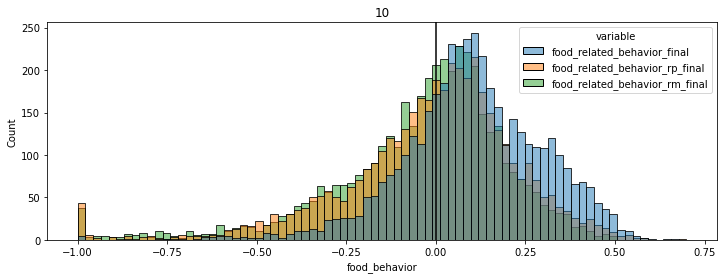

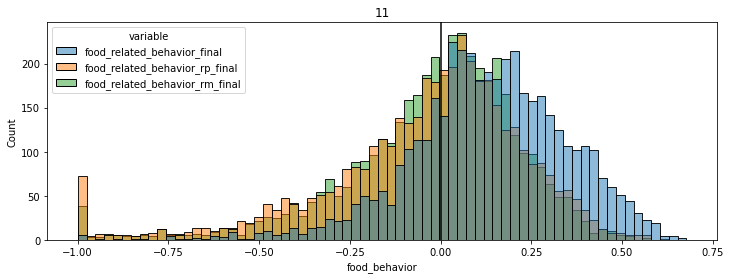

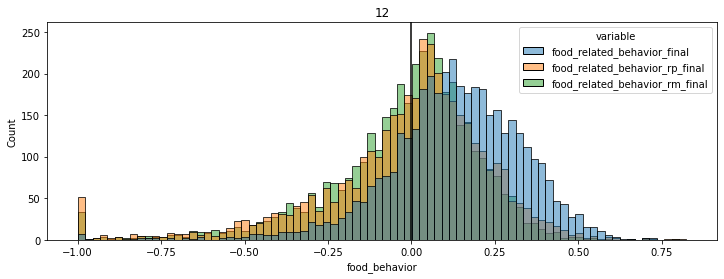

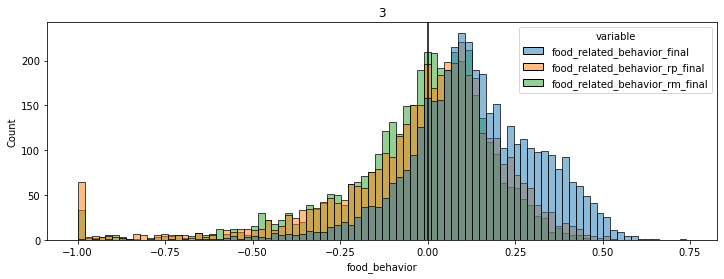

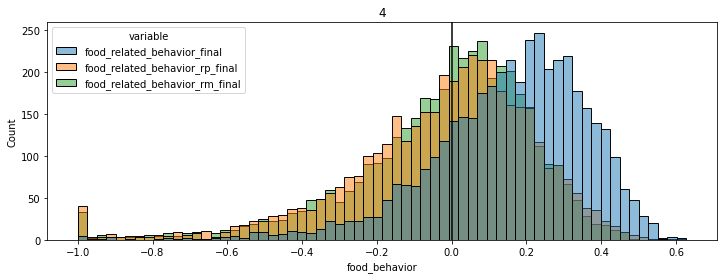

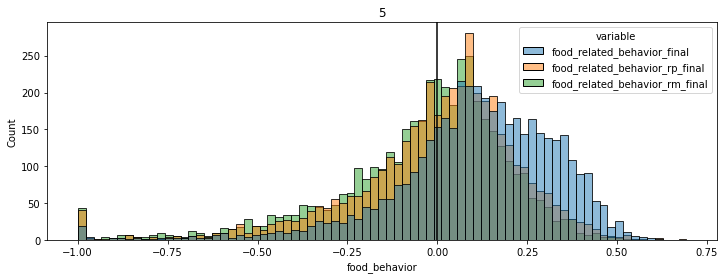

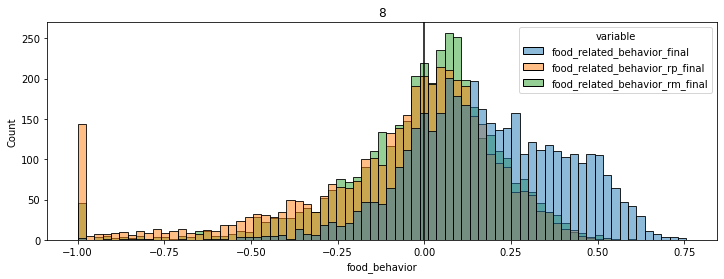

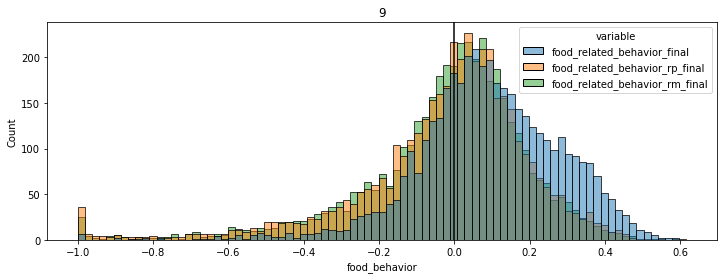

In [46]:
#per pen
pal_ = {'food_related_behavior_rm_final':'darkorange',
        'food_related_behavior_rp_final':'indianred',
        'food_related_behavior_final':'steelblue'}
for penid in df_plt['PenID'].unique():
    plt.figure(figsize=(12,4))
    sns.histplot(df_plt[df_plt['PenID']==penid], x='food_behavior', kde=False, hue='variable');
    plt.axvline(0, color='black');
    plt.title(penid)
    plt.show();

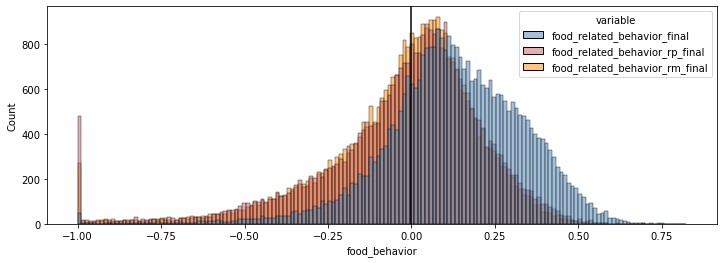

In [47]:
#alltogether
plt.figure(figsize=(12,4))
sns.histplot(df_plt, x='food_behavior', kde=False, hue='variable', palette=pal_);
plt.axvline(0, color='black');
plt.savefig(os.path.join(path_extracted_data, 'FoodRI_density.png'),dpi=300,format='png',bbox_inches='tight')

In [48]:
#almost non are 0
df_plt[df_plt['food_behavior']==0].shape[0]/df_plt[df_plt['food_behavior']!=0].shape[0]*100

0.019979022026871785

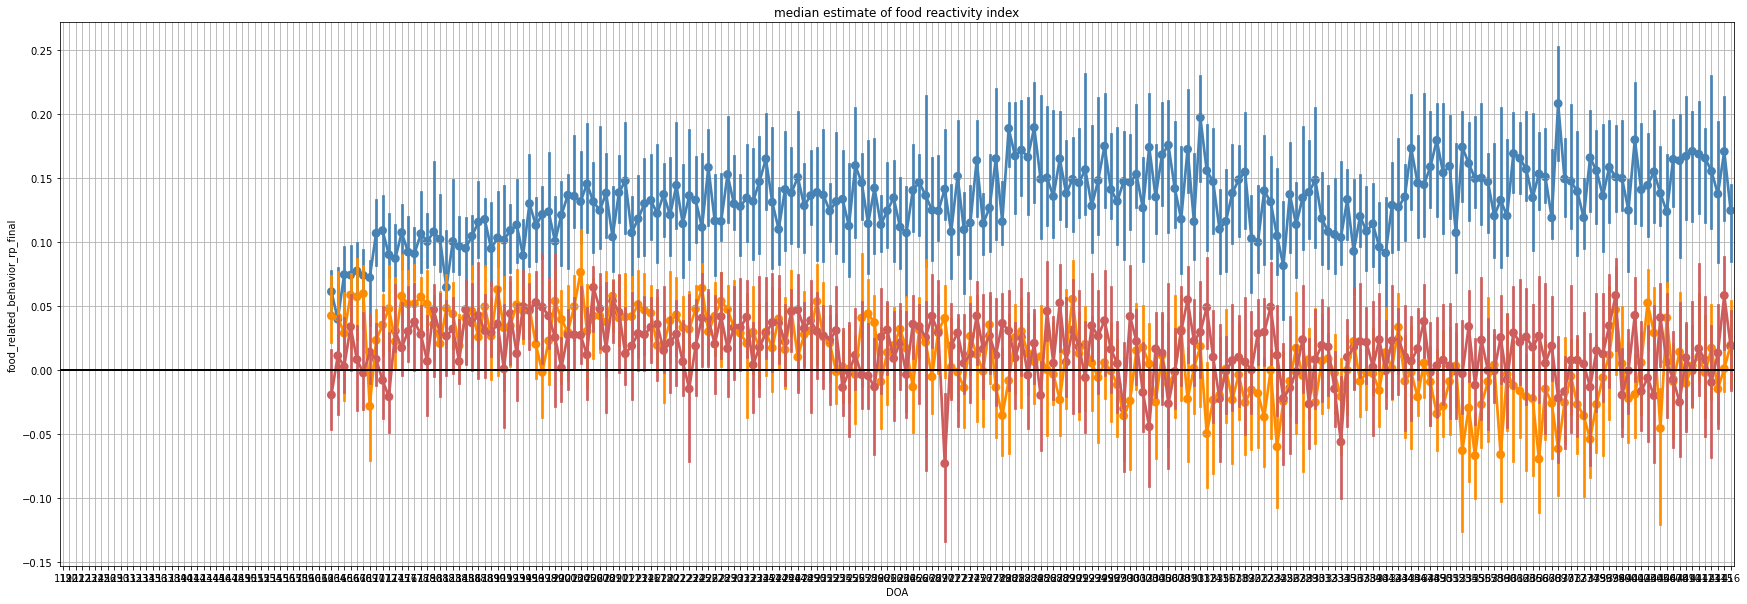

In [49]:
#median
plt.figure(figsize=(30,10))
sns.pointplot(y='food_related_behavior_final', x='DOA', color=pal_['food_related_behavior_final'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_related_behavior_rm_final', x='DOA', color=pal_['food_related_behavior_rm_final'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_related_behavior_rp_final', x='DOA', color=pal_['food_related_behavior_rp_final'], data=df_daily, 
              estimator=np.median);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('median estimate of food reactivity index')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'FoodRI_overtime_median.png'),dpi=300,format='png',bbox_inches='tight')

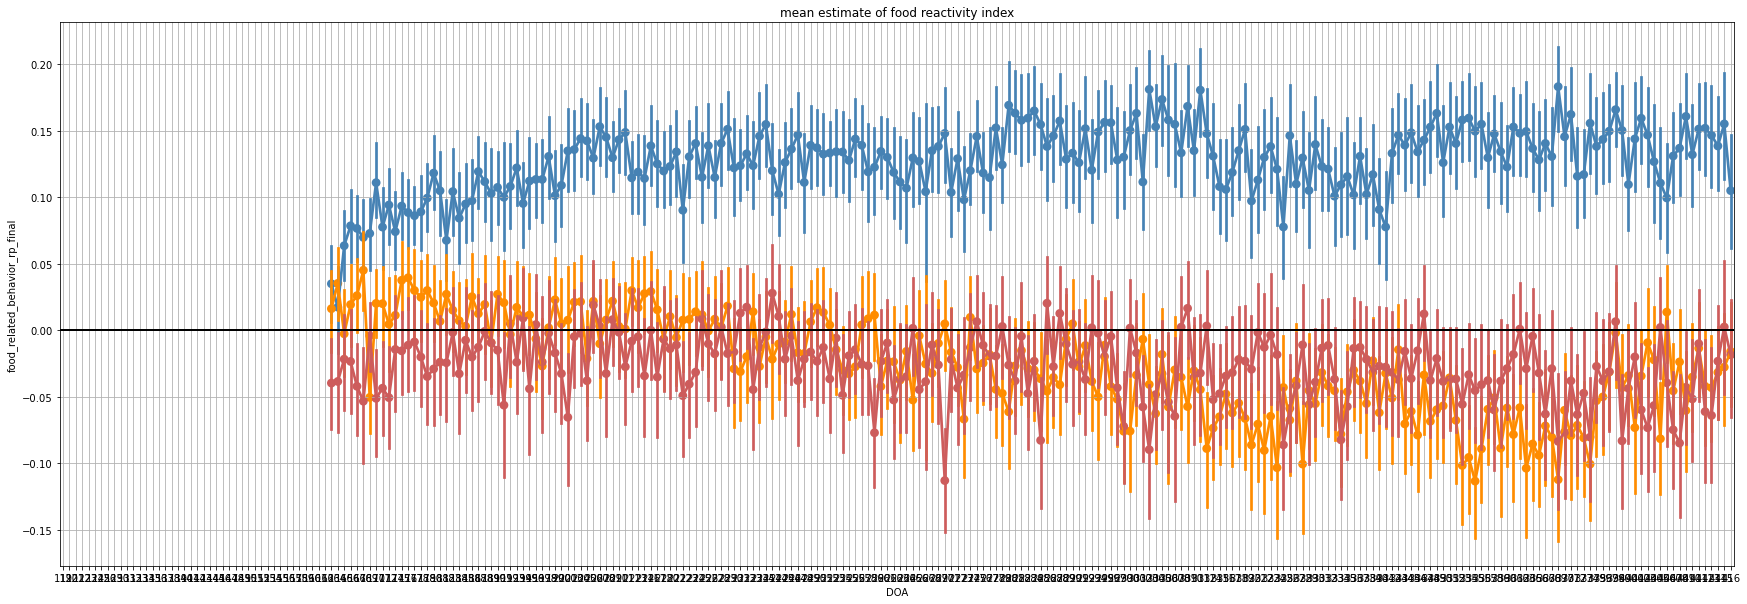

In [50]:
#mean
plt.figure(figsize=(30,10))
sns.pointplot(y='food_related_behavior_final', x='DOA', color=pal_['food_related_behavior_final'], data=df_daily, 
              estimator=np.mean,  s=0.1);
sns.pointplot(y='food_related_behavior_rm_final', x='DOA', color=pal_['food_related_behavior_rm_final'], data=df_daily, 
              estimator=np.mean, s=0.1);
sns.pointplot(y='food_related_behavior_rp_final', x='DOA', color=pal_['food_related_behavior_rp_final'], data=df_daily, 
              estimator=np.mean, s=0.1);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('mean estimate of food reactivity index')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'FoodRI_overtime_mean.png'),dpi=300,format='png',bbox_inches='tight')

### better measure

In [51]:
#food_related_behavior should be replaced by food_related_behavior4 from the 28.03.2021 due to summer time changed that
#probably changed the computer programe timing too
df_daily['food_sameDurTiming_r50_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_sameDurTiming_r50'], df_daily['food_sameDurTiming_r50_4mn'])
df_daily['food_sameDurTiming_r50_AP_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_sameDurTiming_r50_AP'], df_daily['food_sameDurTiming_r50_AP_4mn'])
df_daily['food_sameDurTiming_r50_AB_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_sameDurTiming_r50_AB'], df_daily['food_sameDurTiming_r50_AB_4mn'])

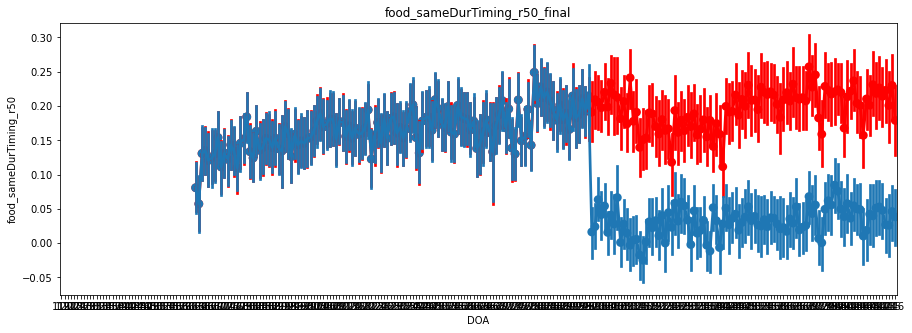

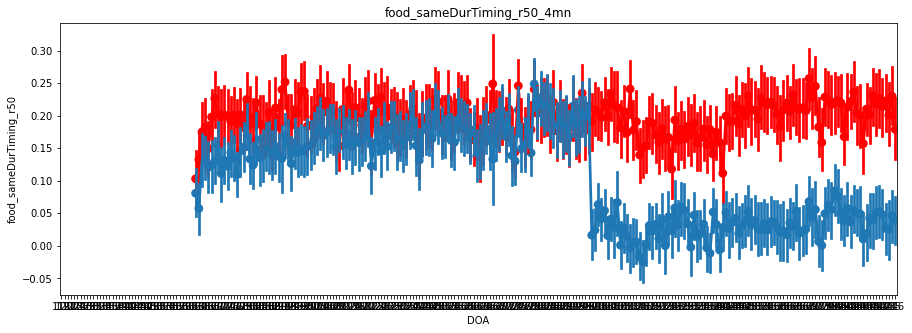

In [52]:
#small verification: CORRECT!
li_food = ['food_sameDurTiming_r50_final','food_sameDurTiming_r50_4mn']
for b in li_food:
    plt.figure(figsize=(15,5))
    sns.pointplot(y=b, x='DOA', color='red', data=df_daily);
    sns.pointplot(y='food_sameDurTiming_r50', x='DOA',  data=df_daily);
    plt.title(b)
    plt.show();

In [53]:
df_plt = pd.melt(df_daily[df_daily['level']>config.date_consistent_barn_schedule], id_vars=['HenID','WOA','level','PenID'], 
        value_vars=['food_sameDurTiming_r50_final','food_sameDurTiming_r50_AP_final','food_sameDurTiming_r50_AB_final'],
        value_name='food_behavior')
df_plt['is_positive'] = df_plt['food_behavior'].map(lambda x: int(x>0))
display(df_plt.head(3))
#display(df_plt.groupby(['variable'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index())
df_plt_ = df_plt.groupby(['variable','level'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index()
display(df_plt_.head(3))
df_plt_.groupby(['variable']).agg(mean_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.nanmean(x)),
           sd_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.std(x))).reset_index()
#weekly average +-SD of the mean daily food-related behavior across individuals

,HenID,WOA,level,PenID,variable,food_behavior,is_positive
0,hen_131,24,2020-11-14,10,food_sameDurTiming_r50_final,0.244604,1
1,hen_131,24,2020-11-15,10,food_sameDurTiming_r50_final,0.224889,1
2,hen_131,24,2020-11-16,10,food_sameDurTiming_r50_final,-0.300236,0


,variable,level,is_positive
0,food_sameDurTiming_r50_AB_final,2020-11-14,61.538462
1,food_sameDurTiming_r50_AB_final,2020-11-15,57.051282
2,food_sameDurTiming_r50_AB_final,2020-11-16,64.743590


,variable,mean_is_positive,sd_is_positive
0,food_sameDurTiming_r50_AB_final,52.362872,4.927678
1,food_sameDurTiming_r50_AP_final,52.073750,4.138463
2,food_sameDurTiming_r50_final,74.749132,3.750520


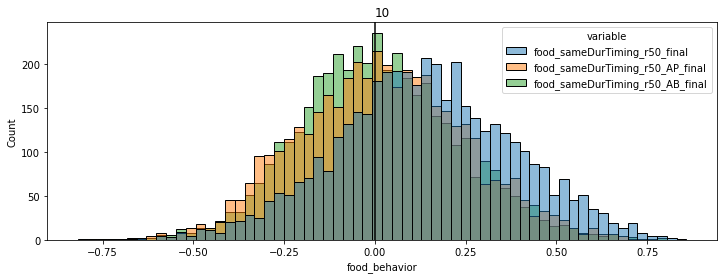

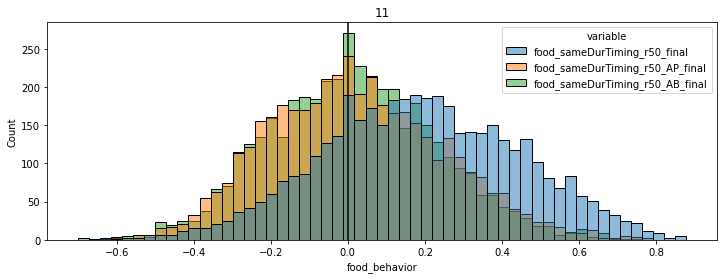

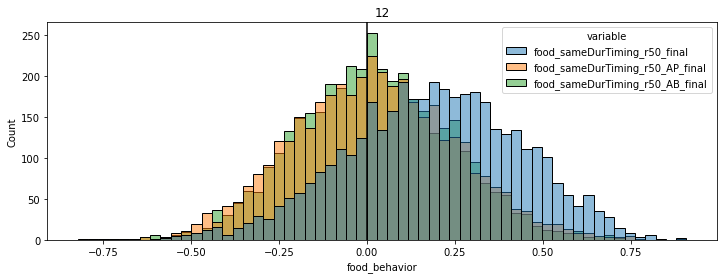

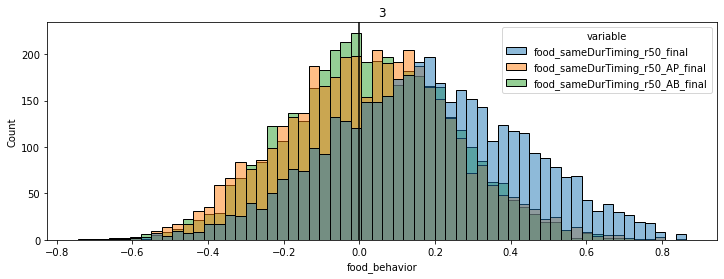

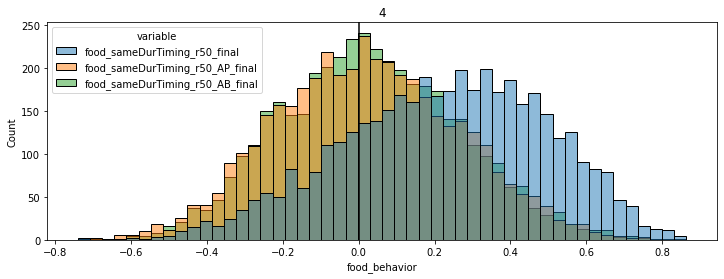

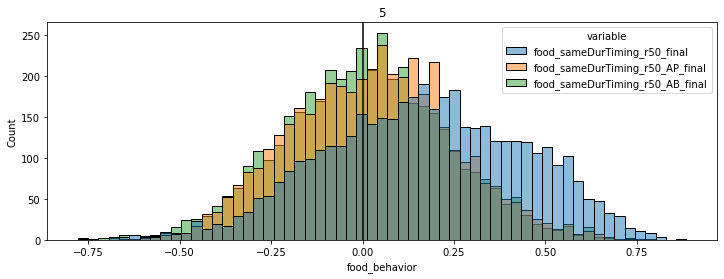

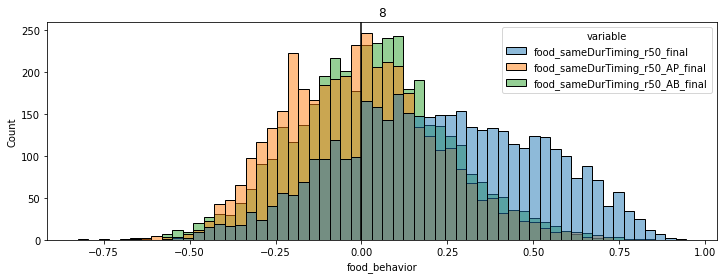

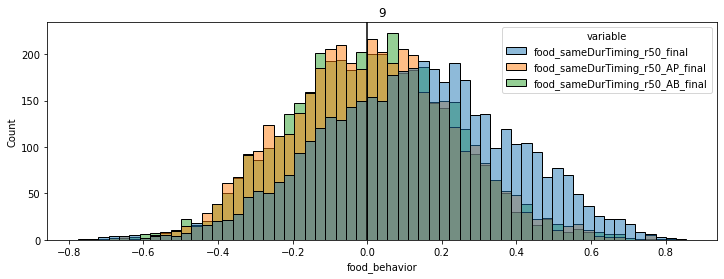

In [54]:
#per pen
for penid in df_plt['PenID'].unique():
    plt.figure(figsize=(12,4))
    pal_ = {'food_sameDurTiming_r50_AB_final':'darkorange',
            'food_sameDurTiming_r50_AP_final':'indianred',
            'food_sameDurTiming_r50_final':'steelblue'}
    sns.histplot(df_plt[df_plt['PenID']==penid], x='food_behavior', kde=False, hue='variable');
    plt.axvline(0, color='black');
    plt.title(penid)
    plt.show();

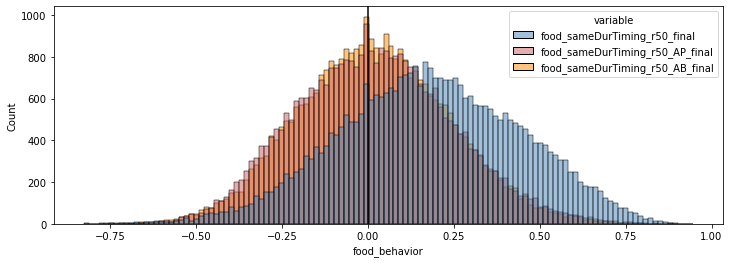

In [55]:
#alltogether
plt.figure(figsize=(12,4))
sns.histplot(df_plt, x='food_behavior', kde=False, hue='variable', palette=pal_);
plt.axvline(0, color='black');
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_density.png'),dpi=300,format='png',bbox_inches='tight')

In [56]:
#nbr of 0
df_plt[df_plt['food_behavior']==0].shape[0]/df_plt[df_plt['food_behavior']!=0].shape[0]*100

0.39707607616641094

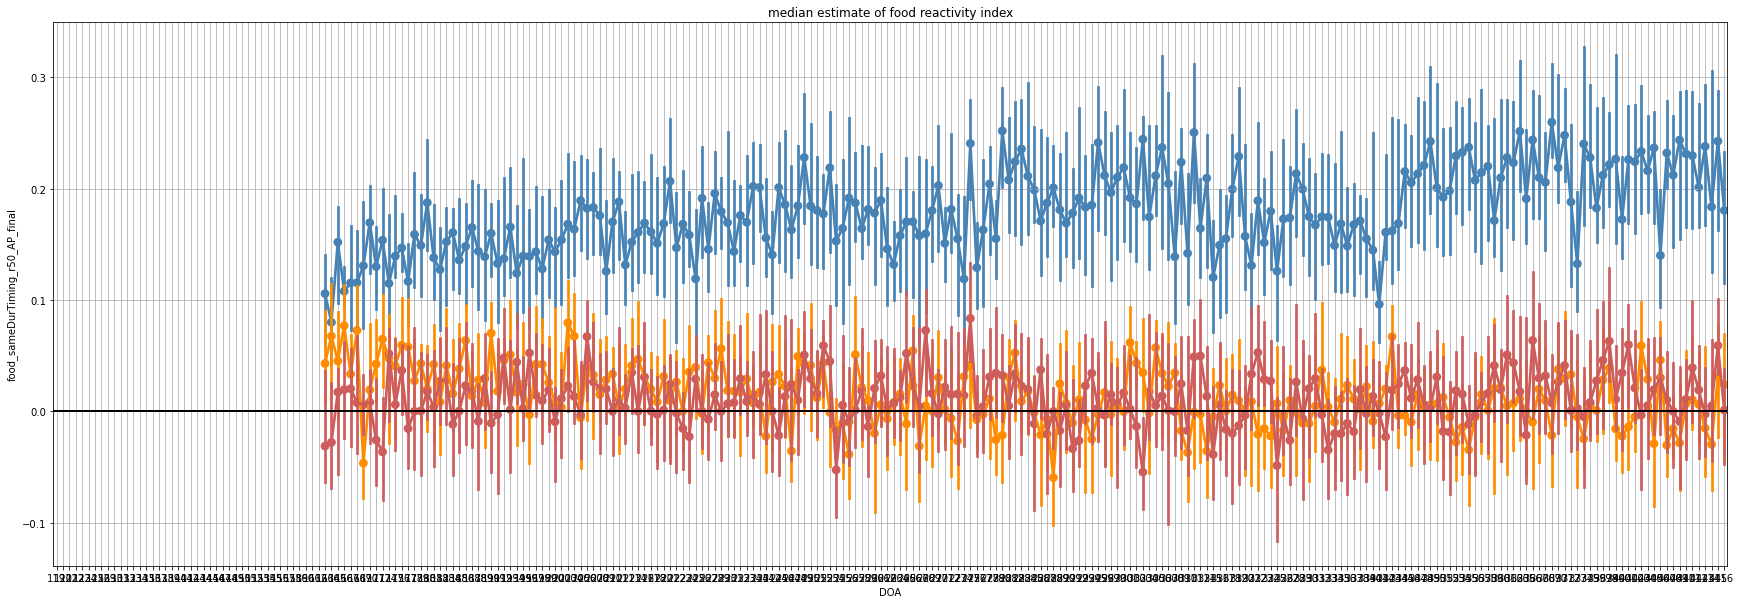

In [58]:
#median
plt.figure(figsize=(30,10))
sns.pointplot(y='food_sameDurTiming_r50_final', x='DOA', color=pal_['food_sameDurTiming_r50_final'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_sameDurTiming_r50_AB_final', x='DOA', color=pal_['food_sameDurTiming_r50_AB_final'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_sameDurTiming_r50_AP_final', x='DOA', color=pal_['food_sameDurTiming_r50_AP_final'], data=df_daily, 
              estimator=np.median);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('median estimate of food reactivity index')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_overtime_median.png'),dpi=300,format='png',bbox_inches='tight')

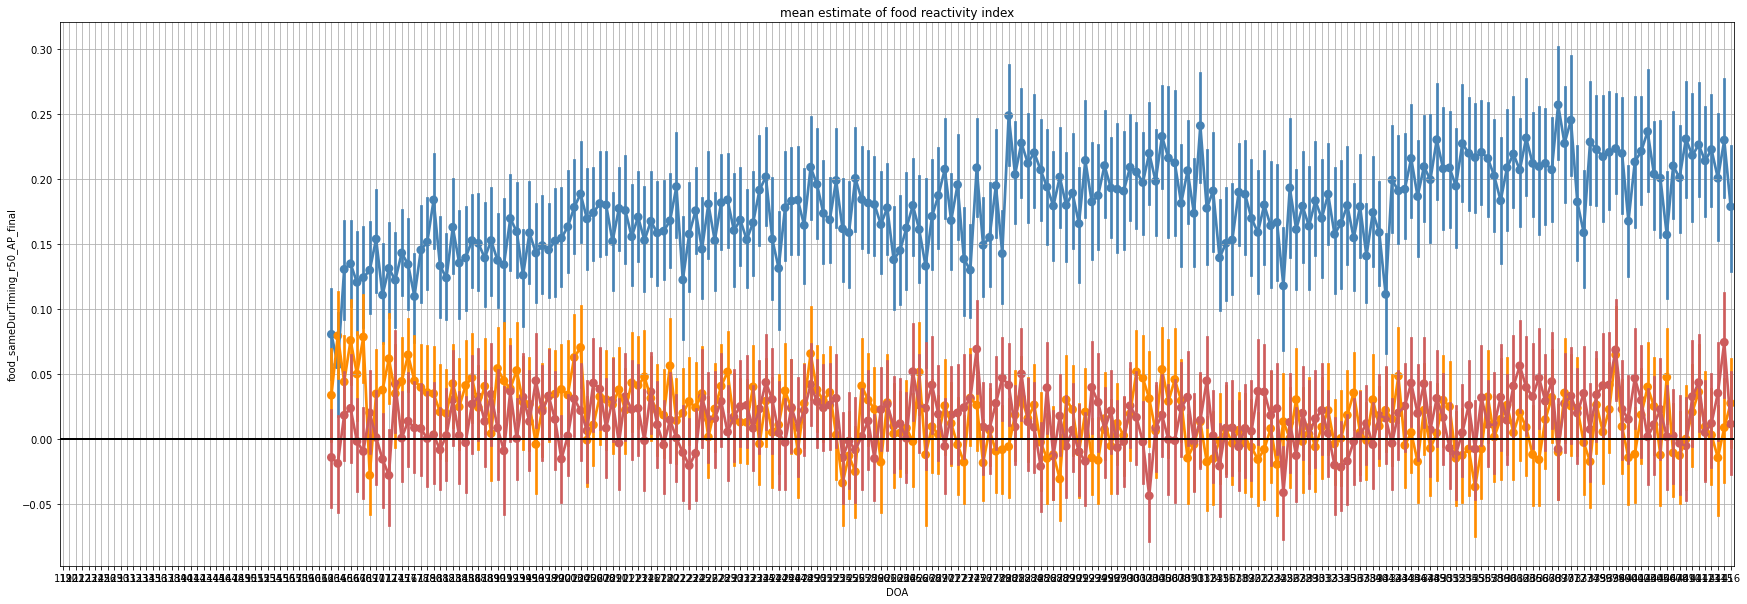

In [59]:
#mean
plt.figure(figsize=(30,10))
sns.pointplot(y='food_sameDurTiming_r50_final', x='DOA', color=pal_['food_sameDurTiming_r50_final'], data=df_daily, 
              estimator=np.mean,  s=0.1);
sns.pointplot(y='food_sameDurTiming_r50_AB_final', x='DOA', color=pal_['food_sameDurTiming_r50_AB_final'], data=df_daily, 
              estimator=np.mean, s=0.1);
sns.pointplot(y='food_sameDurTiming_r50_AP_final', x='DOA', color=pal_['food_sameDurTiming_r50_AP_final'], data=df_daily, 
              estimator=np.mean, s=0.1);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('mean estimate of food reactivity index')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_overtime_mean.png'),dpi=300,format='png',bbox_inches='tight')

# Dates tracked and name

In [60]:
#verify this was remove
df_daily[~((df_daily['level']<dt.datetime(2021,6,14))|(df_daily['level']>dt.datetime(2021,7,3)))]

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,KBF_interp,FeatherDamage_interp,weight_interp,HenID_WIB,food_related_behavior_final,food_related_behavior_rp_final,food_related_behavior_rm_final,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final


In [61]:
#verify this was remove
df_daily[((df_daily['HenID']=='hen_158')&(df_daily['level']>dt.datetime(2021,5,1)))]

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,KBF_interp,FeatherDamage_interp,weight_interp,HenID_WIB,food_related_behavior_final,food_related_behavior_rp_final,food_related_behavior_rm_final,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final


In [62]:
#verify this was remove
df_daily[((df_daily['HenID']=='hen_56')&(df_daily['level']>dt.datetime(2020,11,29))&\
                    (df_daily['level']<dt.datetime(2021,1,4)))]

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,KBF_interp,FeatherDamage_interp,weight_interp,HenID_WIB,food_related_behavior_final,food_related_behavior_rp_final,food_related_behavior_rm_final,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final


In [63]:
#verify hen_129 is not here althought it was in focal bird with 0 workign tracked days!
if df_daily[df_daily['HenID']=='hen_129'].shape[0]>0:
    print('ERROR')
    sys.exit()
df_daily[df_daily['HenID']=='hen_129']

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,KBF_interp,FeatherDamage_interp,weight_interp,HenID_WIB,food_related_behavior_final,food_related_behavior_rp_final,food_related_behavior_rm_final,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final


In [64]:
df_daily[df_daily['level']==dt.datetime(2020,9,30)][['PenID','nbr_h_per_day','correct_amount_of_hour','level']].head(5)

,PenID,nbr_h_per_day,correct_amount_of_hour,level
3,10,8,True,2020-09-30
113,10,8,True,2020-09-30
367,10,8,True,2020-09-30
620,10,8,True,2020-09-30
874,10,8,True,2020-09-30


In [65]:
df_daily[['PenID','nbr_h_per_day','correct_amount_of_hour','level','Total_number_transition','verification_daily_total_duration']].head(5)

,PenID,nbr_h_per_day,correct_amount_of_hour,level,Total_number_transition,verification_daily_total_duration
0,10,9,True,2020-10-05,0.0,32400.0
1,10,9,True,2020-10-06,3.0,32400.0
2,10,9,True,2020-10-07,4.0,32400.0
3,10,8,True,2020-09-30,5.0,28800.0
4,10,9,True,2020-10-01,9.0,32400.0


In [66]:
df_daily[['level','DIB','WIB','DOA','WOA']].head(5)

,level,DIB,WIB,DOA,WOA
0,2020-10-05,6,1,124,18
1,2020-10-06,7,1,125,18
2,2020-10-07,8,2,126,18
3,2020-09-30,1,1,119,17
4,2020-10-01,2,1,120,18


# Daily Variables

In [67]:
li_var = list(df_daily.columns)
li_general = ['HenID', 'level','PenID']
li_var_TODO = li_var #keep track of the columns that still needs to be verified
len(li_var_TODO)
#display(list(li_var))

117

In [68]:
#print all column with nan
#df_daily.columns[df_daily.isna().any()].tolist()

## Hens variables + disturbances days

In [69]:
li_hens = ['CLASS','TagID','FocalLegringName','R-Pen','InitialStartDate']
print(li_hens)

['CLASS', 'TagID', 'FocalLegringName', 'R-Pen', 'InitialStartDate']


In [70]:
#specific bird (in pen 9, should not be  here on the 3,4,5, 8, 9 th of OCtober it should have NO data at all
h = 'hen_90'
d = dt.datetime(2020,10,10)
df_daily[(df_daily['HenID']==h)&(df_daily['level']<=d)][li_general+li_hens+['duration_5_Zone',
                                                                            'night_Max_duration_zones']].sort_values(['level'])

,HenID,level,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,duration_5_Zone,night_Max_duration_zones
38621,hen_90,2020-09-30,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,0.0,5_Zone
38622,hen_90,2020-10-01,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,783.0,3_Zone
38623,hen_90,2020-10-02,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,0.0,3_Zone
38624,hen_90,2020-10-06,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,31451.0,5_Zone
38625,hen_90,2020-10-07,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,32400.0,5_Zone
38626,hen_90,2020-10-10,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,35275.0,5_Zone


In [71]:
#verify that the day with weird device day (can be find here: *_df_alldeviceinfo) are removed
#hen_147 - tag 82: 25.01-03.02 not working (due to rfid installation and then tag bugging) 
h = 'hen_147'
dmin = dt.datetime(2021,1,24)
dmax = dt.datetime(2021,2,10)
df_daily[(df_daily['HenID']==h)&(df_daily['level']<=dmax)&(df_daily['level']>=dmin)][li_general+li_hens].sort_values(['level'])
#TO CHECK: Pen ID here even when the day variables is not here?
#TO DO AT THE END OF THE STUDY: check each indivudal case of GAP: e.g. tag 171 (hen 133) had big gaps on the 11.01.2021
#sometimes its nan due to the student that wrote +-30/70 (weight 04-01-2021, pen 12)
#CORRECT!

,HenID,level,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate
30705,hen_147,2021-01-24,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30706,hen_147,2021-02-03,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30707,hen_147,2021-02-04,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30708,hen_147,2021-02-05,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30709,hen_147,2021-02-06,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30710,hen_147,2021-02-07,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30711,hen_147,2021-02-08,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30712,hen_147,2021-02-09,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30713,hen_147,2021-02-10,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00


In [72]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_hens]
len(li_var_TODO)

112

# food related behavior

In [73]:
#will be better checked visually in 4.b. notebook (more easy)
display(df_daily[df_daily['food_related_behavior_final']>0.5].tail(3))
h = 'hen_29'
d = dt.datetime(2020,10,19)
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==(d+dt.timedelta(days=1))))]
display(df_daily[(df_daily['HenID']==h)&((df_daily['level']==d)|\
                                         (df_daily['level']==(d+dt.timedelta(days=1))))][li_general+['food_related_behavior_final']].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,KBF_interp,FeatherDamage_interp,weight_interp,HenID_WIB,food_related_behavior_final,food_related_behavior_rp_final,food_related_behavior_rm_final,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final
39322,hen_98,2021-05-05,1675.0,27934.0,8059.0,7193.0,9139.0,54000.0,15.0,"[1675.0, 27934.0, 8059.0, 7193.0, 9139.0]",...,19.538462,17.003205,1743.238462,hen_98-WIB32,0.580027,-0.089783,0.057166,0.501313,0.038069,0.176306
39325,hen_98,2021-05-08,2498.0,28591.0,7271.0,6917.0,8723.0,54000.0,15.0,"[2498.0, 28591.0, 7271.0, 6917.0, 8723.0]",...,20.000000,17.916667,1743.700000,hen_98-WIB32,0.578249,0.088859,-0.002947,0.683736,-0.038667,-0.233090
39347,hen_98,2021-05-30,6123.0,23589.0,9211.0,7141.0,7936.0,54000.0,15.0,"[6123.0, 23589.0, 9211.0, 7141.0, 7936.0]",...,23.384615,24.615385,1747.084615,hen_98-WIB35,0.507856,-0.979374,-0.462018,0.609972,-0.475167,-0.195514


,HenID,level,PenID,food_related_behavior_final
38020,hen_29,2020-10-19,9,NaN
38021,hen_29,2020-10-20,9,NaN


((Timestamp('2020-10-19 07:45:18'), '4_Zone'),
 (Timestamp('2020-10-19 07:45:32'), '3_Zone'),
 (Timestamp('2020-10-19 07:56:09'), '2_Zone'),
 (Timestamp('2020-10-19 07:59:29'), '2_Zone'),
 (Timestamp('2020-10-19 10:31:13'), '3_Zone'),
 (Timestamp('2020-10-19 10:46:23'), '2_Zone'),
 (Timestamp('2020-10-19 11:26:25'), '2_Zone'),
 (Timestamp('2020-10-19 11:54:49'), '3_Zone'),
 (Timestamp('2020-10-19 12:05:47'), '4_Zone'),
 (Timestamp('2020-10-19 12:09:22'), '5_Zone'),
 (Timestamp('2020-10-19 12:33:29'), '2_Zone'),
 (Timestamp('2020-10-19 12:33:58'), '1_Zone'),
 (Timestamp('2020-10-19 12:39:38'), '2_Zone'),
 (Timestamp('2020-10-19 12:40:13'), '1_Zone'),
 (Timestamp('2020-10-19 12:53:13'), '2_Zone'),
 (Timestamp('2020-10-19 12:57:31'), '1_Zone'),
 (Timestamp('2020-10-19 12:58:47'), '2_Zone'),
 (Timestamp('2020-10-19 12:59:27'), '1_Zone'),
 (Timestamp('2020-10-19 13:01:00'), '2_Zone'),
 (Timestamp('2020-10-19 13:02:07'), '1_Zone'),
 (Timestamp('2020-10-19 13:08:36'), '2_Zone'),
 (Timestamp('

## Night

In [74]:
df_daily['night_duration_Z5'].value_counts()

32400.0    21378
0.0        10785
39600.0      774
46800.0      652
43200.0      603
           ...  
755.0          1
659.0          1
2335.0         1
1198.0         1
1405.0         1
Name: night_duration_Z5, Length: 2000, dtype: int64

In [75]:
li_night = [i for i in li_var_TODO if ('night' in i)]+['SleepingHeight']
li_night

['night_level',
 'night_Max_duration_zones',
 'night_duration_Z5',
 'night_Total_number_transition',
 'is_mvt_night',
 'SleepingHeight']

In [76]:
df_daily['SleepingHeight'].unique()

array([ 3.,  1.,  2.,  0., nan])

In [77]:
#another bird, based on:
#display(df_daily[df_daily['level']==dt.datetime(2020,10,7)].head(3))
h = 'hen_130'
d = dt.datetime(2020,10,7) #day of a change in the light schedule of the day: on the 7th it turned off at 18h and on the 8th it 
#turned on at 8h (not 9h sas it was on the 7th)
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==(d+dt.timedelta(days=1))))]
display(df_daily[(df_daily['HenID']==h)&((df_daily['level']==d)|(df_daily['level']==(d+dt.timedelta(days=1))))][li_general+li_night].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct 

,HenID,level,PenID,night_level,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,SleepingHeight
2,hen_130,2020-10-07,10,2020-10-07_08,5_Zone,54000.0,0.0,0.0,3.0


((Timestamp('2020-10-07 09:03:45'), '2_Zone'),
 (Timestamp('2020-10-07 09:07:11'), '3_Zone'),
 (Timestamp('2020-10-07 09:07:35'), '4_Zone'),
 (Timestamp('2020-10-07 09:09:45'), '5_Zone'))

In [78]:
h = 'hen_131'
d = dt.datetime(2020,10,7) #day of a change in the light schedule of the day: on the 7th it turned off at 18h and on the 8th it 
#turned on at 8h (not 9h sas it was on the 7th)
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==(d+dt.timedelta(days=1))))]
display(df_daily[(df_daily['HenID']==h)&((df_daily['level']==d)|(df_daily['level']==(d+dt.timedelta(days=1))))][li_general+li_night].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct 

,HenID,level,PenID,night_level,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,SleepingHeight
9,hen_131,2020-10-07,10,2020-10-07_08,5_Zone,48644.0,2.0,1.0,3.0


((Timestamp('2020-10-07 07:04:36'), '5_Zone'),
 (Timestamp('2020-10-07 07:42:01'), '3_Zone'),
 (Timestamp('2020-10-07 07:58:06'), '5_Zone'),
 (Timestamp('2020-10-07 08:16:44'), '3_Zone'),
 (Timestamp('2020-10-07 10:49:35'), '2_Zone'),
 (Timestamp('2020-10-07 12:41:20'), '3_Zone'),
 (Timestamp('2020-10-07 13:08:51'), '2_Zone'),
 (Timestamp('2020-10-07 14:36:38'), '3_Zone'),
 (Timestamp('2020-10-07 15:11:27'), '2_Zone'),
 (Timestamp('2020-10-07 16:14:49'), '3_Zone'),
 (Timestamp('2020-10-07 16:25:00'), '2_Zone'),
 (Timestamp('2020-10-07 17:52:21'), '3_Zone'),
 (Timestamp('2020-10-07 17:54:24'), '4_Zone'),
 (Timestamp('2020-10-07 18:08:53'), '5_Zone'),
 (Timestamp('2020-10-08 07:39:37'), '4_Zone'),
 (Timestamp('2020-10-08 09:05:32'), '3_Zone'),
 (Timestamp('2020-10-08 09:37:04'), '2_Zone'),
 (Timestamp('2020-10-08 11:40:21'), '3_Zone'),
 (Timestamp('2020-10-08 11:42:05'), '2_Zone'),
 (Timestamp('2020-10-08 11:54:41'), '3_Zone'),
 (Timestamp('2020-10-08 12:24:34'), '2_Zone'),
 (Timestamp('

In [79]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_night]
print(len(li_var_TODO))

106


## Transitions in aviary (zone 1, zone 2, zone 3, zone 4)

#### first timestamp in each zones and latency

In [80]:
li_latency = [i for i in li_var if 'latency_' in i]
li_first_timestamp = [i for i in li_var if 'FirstTimestamp' in i]+['Total_number_zone']

In [81]:
#random bird
h = 'hen_89'
d = dt.datetime(2020,11,18) #until 17h
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_first_timestamp+li_latency])
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

,HenID,level,PenID,FirstTimestamp_1_Zone,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone,latency_1_Zone_h
29480,hen_89,2020-11-18,5,NaT,2020-11-18 06:44:25,2020-11-18 05:25:03,2020-11-18 04:56:38,2020-11-18 02:00:00,NaN,4.0,6.583333


((Timestamp('2020-11-18 04:56:38'), '4_Zone'),
 (Timestamp('2020-11-18 05:25:03'), '3_Zone'),
 (Timestamp('2020-11-18 06:44:25'), '2_Zone'),
 (Timestamp('2020-11-18 07:45:10'), '3_Zone'),
 (Timestamp('2020-11-18 07:56:47'), '4_Zone'),
 (Timestamp('2020-11-18 07:57:11'), '5_Zone'),
 (Timestamp('2020-11-18 10:35:53'), '2_Zone'),
 (Timestamp('2020-11-18 10:39:58'), '3_Zone'),
 (Timestamp('2020-11-18 10:44:03'), '4_Zone'),
 (Timestamp('2020-11-18 10:44:14'), '5_Zone'))

In [82]:
#specific bird
#df_daily[li_general+li_first_timestamp].head(3)
h = 'hen_130'
d = dt.datetime(2020,10,6)
df = df_init[(df_init['HenID']==h)&(df_init['date']<=d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']<=d)]
display(X[li_general+li_first_timestamp+li_latency+['verification_daily_total_duration']])
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

,HenID,level,PenID,FirstTimestamp_1_Zone,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone,latency_1_Zone_h,verification_daily_total_duration
0,hen_130,2020-10-05,10,NaT,NaT,NaT,NaT,2020-10-05 09:00:00,NaN,1.0,NaN,32400.0
1,hen_130,2020-10-06,10,NaT,NaT,2020-10-06 09:08:52,2020-10-06 09:21:52,2020-10-06 09:00:00,NaN,3.0,NaN,32400.0


((Timestamp('2020-10-04 09:06:42'), '3_Zone'),
 (Timestamp('2020-10-04 09:20:45'), '4_Zone'),
 (Timestamp('2020-10-04 09:21:49'), '5_Zone'),
 (Timestamp('2020-10-04 15:29:51'), '3_Zone'),
 (Timestamp('2020-10-04 15:29:55'), '2_Zone'),
 (Timestamp('2020-10-04 15:32:15'), '3_Zone'),
 (Timestamp('2020-10-04 15:37:34'), '4_Zone'),
 (Timestamp('2020-10-04 15:37:49'), '5_Zone'),
 (Timestamp('2020-10-06 09:08:52'), '3_Zone'),
 (Timestamp('2020-10-06 09:21:52'), '4_Zone'),
 (Timestamp('2020-10-06 09:27:17'), '5_Zone'),
 (Timestamp('2020-10-06 19:29:23'), '3_Zone'))

In [83]:
#specific bird
#df_daily[li_general+li_first_timestamp].head(3)
h = 'hen_90'
d = dt.datetime(2020,10,6) #3,4,5 : tracking should not be used
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_first_timestamp].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

,HenID,level,PenID,FirstTimestamp_1_Zone,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone
38624,hen_90,2020-10-06,9,NaT,2020-10-06 11:57:00,2020-10-06 12:07:21,2020-10-06 12:09:00,2020-10-06 09:00:00,NaN,4.0


((Timestamp('2020-10-06 11:57:00'), '2_Zone'),
 (Timestamp('2020-10-06 12:07:21'), '3_Zone'),
 (Timestamp('2020-10-06 12:09:00'), '4_Zone'),
 (Timestamp('2020-10-06 12:12:49'), '5_Zone'))

In [84]:
#specific bird that went in wg!
#df_daily[li_general+li_first_timestamp].head(3)
h = 'hen_109'
d = dt.datetime(2021,3,10) #3,4,5 : tracking should not be used
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_first_timestamp].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
14*60*60+57*60+17  #= 53837 correct
#-->correct!

,HenID,level,PenID,FirstTimestamp_1_Zone,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone
25295,hen_109,2021-03-10,5,2021-03-10 14:57:17,2021-03-10 02:11:56,2021-03-10 02:00:00,2021-03-10 02:59:46,2021-03-10 02:28:29,53837.0,5.0


((Timestamp('2021-03-10 02:11:56'), '2_Zone'),
 (Timestamp('2021-03-10 02:23:10'), '3_Zone'),
 (Timestamp('2021-03-10 02:28:29'), '5_Zone'),
 (Timestamp('2021-03-10 02:59:46'), '4_Zone'),
 (Timestamp('2021-03-10 03:00:05'), '3_Zone'),
 (Timestamp('2021-03-10 03:00:21'), '2_Zone'),
 (Timestamp('2021-03-10 03:30:03'), '3_Zone'),
 (Timestamp('2021-03-10 03:32:31'), '2_Zone'),
 (Timestamp('2021-03-10 03:43:24'), '3_Zone'),
 (Timestamp('2021-03-10 03:48:36'), '5_Zone'),
 (Timestamp('2021-03-10 03:51:21'), '4_Zone'),
 (Timestamp('2021-03-10 03:53:02'), '5_Zone'),
 (Timestamp('2021-03-10 04:18:25'), '4_Zone'),
 (Timestamp('2021-03-10 05:24:26'), '3_Zone'),
 (Timestamp('2021-03-10 05:27:57'), '2_Zone'),
 (Timestamp('2021-03-10 05:35:29'), '3_Zone'),
 (Timestamp('2021-03-10 05:48:36'), '2_Zone'),
 (Timestamp('2021-03-10 05:59:25'), '3_Zone'),
 (Timestamp('2021-03-10 06:07:50'), '5_Zone'),
 (Timestamp('2021-03-10 06:53:21'), '4_Zone'),
 (Timestamp('2021-03-10 06:53:31'), '3_Zone'),
 (Timestamp('

53837

In [85]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_first_timestamp]
li_var_TODO = [i for i in li_var_TODO if i not in li_latency]
len(li_var_TODO)

98

### transitions & stays

In [86]:
li_transition_rest = ['vertical_travel_distance','Total_number_transition','vertical_travel_distance_dawn',
                      'vertical_travel_distance_dusk','vertical_travel_distance_fulllight_perinsideh',
                      'vertical_travel_distance_fulllight']

In [87]:
df_daily[(df_daily['vertical_travel_distance_dawn'].isnull())&(df_daily['level']>config.date_consistent_barn_schedule)]

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,KBF_interp,FeatherDamage_interp,weight_interp,HenID_WIB,food_related_behavior_final,food_related_behavior_rp_final,food_related_behavior_rm_final,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final


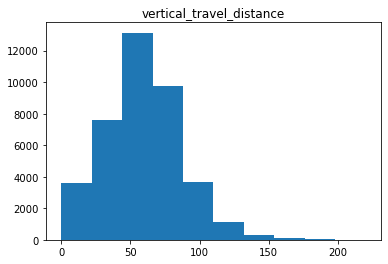

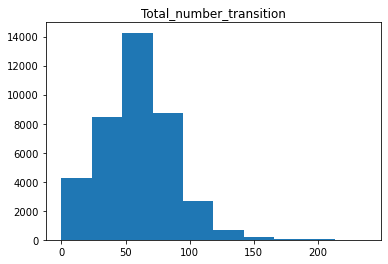

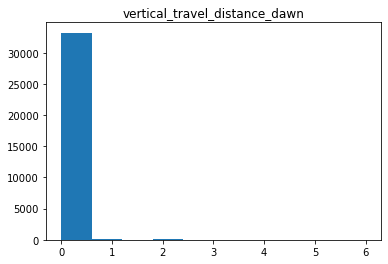

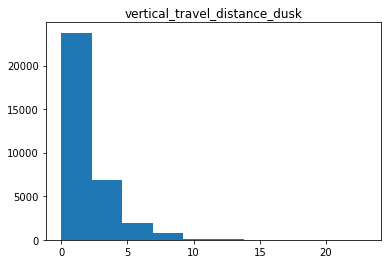

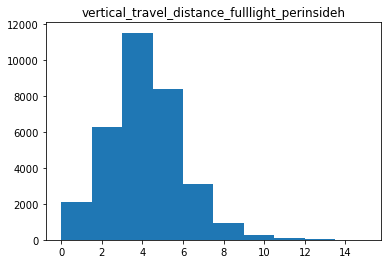

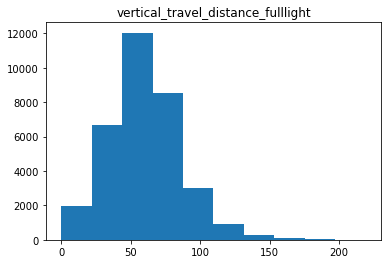

In [88]:
for x in li_transition_rest:
    plt.hist(df_daily[x])
    plt.title(x)
    plt.show()

In [89]:
df_daily[df_daily['vertical_travel_distance_dawn']>0][li_transition_rest]

,vertical_travel_distance,Total_number_transition,vertical_travel_distance_dawn,vertical_travel_distance_dusk,vertical_travel_distance_fulllight_perinsideh,vertical_travel_distance_fulllight
155,65.0,78.0,1.0,3.0,4.431649,62.0
298,61.0,60.0,4.0,2.0,4.098013,59.0
916,79.0,75.0,1.0,3.0,5.140924,76.0
956,90.0,87.0,6.0,4.0,5.817362,86.0
1278,63.0,63.0,1.0,3.0,4.058625,60.0
...,...,...,...,...,...,...
38786,141.0,151.0,2.0,7.0,9.269080,134.0
38788,123.0,165.0,2.0,8.0,8.308748,115.0
38795,107.0,132.0,2.0,7.0,7.060623,100.0
38803,120.0,146.0,1.0,5.0,8.417885,115.0


In [90]:
df_daily.columns

Index(['HenID', 'level', 'duration_1_Zone', 'duration_2_Zone',
       'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone',
       'verification_daily_total_duration',
       'verification_daily_total_nbr_hour', 'dur_values',
       ...
       'KBF_interp', 'FeatherDamage_interp', 'weight_interp', 'HenID_WIB',
       'food_related_behavior_final', 'food_related_behavior_rp_final',
       'food_related_behavior_rm_final', 'food_sameDurTiming_r50_final',
       'food_sameDurTiming_r50_AP_final', 'food_sameDurTiming_r50_AB_final'],
      dtype='object', length=117)

In [91]:
#stay
li_nbr_stays = ['nbr_stays_1_Zone', 'nbr_stays_2_Zone', 'nbr_stays_3_Zone', 'nbr_stays_4_Zone', 'nbr_stays_5_Zone']
df_daily[li_nbr_stays+['nbr_stays_total','nbr_h_per_day','Total_number_transition']]

,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone,nbr_stays_total,nbr_h_per_day,Total_number_transition
0,NaN,0.0,0.0,0.0,1.0,1.0,9,0.0
1,NaN,0.0,1.0,1.0,2.0,4.0,9,3.0
2,NaN,1.0,2.0,1.0,1.0,5.0,9,4.0
3,NaN,3.0,3.0,0.0,0.0,6.0,8,5.0
4,NaN,5.0,3.0,0.0,2.0,10.0,9,9.0
...,...,...,...,...,...,...,...,...
39377,15.0,37.0,25.0,10.0,7.0,94.0,15,93.0
39378,12.0,27.0,26.0,16.0,6.0,87.0,15,86.0
39379,13.0,32.0,27.0,14.0,6.0,92.0,15,91.0
39380,21.0,42.0,28.0,14.0,5.0,110.0,15,109.0


In [92]:
#duration
li_dur = ['duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone']
li_perc = ['perc_'+c for c in li_dur]
df_daily[li_dur+li_perc]

,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,perc_duration_1_Zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
0,NaN,0.0,0.0,0.0,32400.0,NaN,0.0,0.0,0.0,100.0
1,NaN,0.0,780.0,325.0,31295.0,NaN,0.0,2.0,1.0,97.0
2,NaN,206.0,249.0,130.0,31815.0,NaN,1.0,1.0,0.0,98.0
3,NaN,24385.0,4415.0,0.0,0.0,NaN,85.0,15.0,0.0,0.0
4,NaN,22511.0,5946.0,0.0,3943.0,NaN,69.0,18.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...
39377,6689.0,24396.0,4175.0,6437.0,12303.0,12.0,45.0,8.0,12.0,23.0
39378,3736.0,30464.0,5678.0,3584.0,10538.0,7.0,56.0,11.0,7.0,20.0
39379,7927.0,24226.0,5714.0,4269.0,11864.0,15.0,45.0,11.0,8.0,22.0
39380,9643.0,22803.0,6564.0,5669.0,9321.0,18.0,42.0,12.0,10.0,17.0


In [93]:
#verify Total_number_zone==1 if and only if Total_number_transitions==0
display(df_daily[df_daily['Total_number_transition']==0][['Total_number_transition','HenID','level','Total_number_zone']].head(3))
display(df_daily[df_daily['Total_number_zone']==1][['Total_number_transition','HenID','level','Total_number_zone']].head(3))
if df_daily[(df_daily['Total_number_zone']==1)|(df_daily['Total_number_transition']==0)].shape[0]!=df_daily[(df_daily['Total_number_zone']==1)&(df_daily['Total_number_transition']==0)].shape[0]:
    print('ERROR: you dont have: Total_number_zone==1 if and only if Total_number_transitions==0')
    sys.exit()

,Total_number_transition,HenID,level,Total_number_zone
0,0.0,hen_130,2020-10-05,1.0
114,0.0,hen_134,2020-10-01,1.0
116,0.0,hen_134,2020-10-04,1.0


,Total_number_transition,HenID,level,Total_number_zone
0,0.0,hen_130,2020-10-05,1.0
114,0.0,hen_134,2020-10-01,1.0
116,0.0,hen_134,2020-10-04,1.0


In [94]:
#random bird
h = 'hen_130'
d = dt.datetime(2020,10,7)
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_transition_rest].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct

,HenID,level,PenID,vertical_travel_distance,Total_number_transition,vertical_travel_distance_dawn,vertical_travel_distance_dusk,vertical_travel_distance_fulllight_perinsideh,vertical_travel_distance_fulllight
2,hen_130,2020-10-07,10,4.0,4.0,NaN,NaN,NaN,NaN


((Timestamp('2020-10-07 09:03:45'), '2_Zone'),
 (Timestamp('2020-10-07 09:07:11'), '3_Zone'),
 (Timestamp('2020-10-07 09:07:35'), '4_Zone'),
 (Timestamp('2020-10-07 09:09:45'), '5_Zone'))

In [95]:
#another random bird
h = 'hen_30'
d = dt.datetime(2020,10,4) #9h-18h
df = df_init[(df_init['HenID']==h)&(df_init['Timestamp']<=dt.datetime(2020,10,4,18,0,0))]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_transition_rest].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#vertical_travel_distance: 23 is correct (note: it came from 5 to 2 at 12:20:20)
#down_missingZone_mvtPerc corret: 2/20*100=10% (one from 5 to 2 and one from 4 to 2), we had 20 transitions
#--> correct

,HenID,level,PenID,vertical_travel_distance,Total_number_transition,vertical_travel_distance_dawn,vertical_travel_distance_dusk,vertical_travel_distance_fulllight_perinsideh,vertical_travel_distance_fulllight
18122,hen_30,2020-10-04,3,23.0,20.0,NaN,NaN,NaN,NaN


((Timestamp('2020-09-29 09:44:28'), '3_Zone'),
 (Timestamp('2020-09-29 09:47:41'), '2_Zone'),
 (Timestamp('2020-09-29 09:52:07'), '5_Zone'),
 (Timestamp('2020-09-29 15:22:48'), '3_Zone'),
 (Timestamp('2020-09-29 16:25:38'), '4_Zone'),
 (Timestamp('2020-09-29 16:27:06'), '5_Zone'),
 (Timestamp('2020-10-01 17:03:23'), '2_Zone'),
 (Timestamp('2020-10-01 17:09:42'), '3_Zone'),
 (Timestamp('2020-10-01 17:17:16'), '5_Zone'),
 (Timestamp('2020-10-02 17:13:39'), '3_Zone'),
 (Timestamp('2020-10-02 17:19:32'), '4_Zone'),
 (Timestamp('2020-10-02 17:20:28'), '5_Zone'),
 (Timestamp('2020-10-04 12:20:20'), '2_Zone'),
 (Timestamp('2020-10-04 13:21:13'), '3_Zone'),
 (Timestamp('2020-10-04 13:23:18'), '4_Zone'),
 (Timestamp('2020-10-04 13:32:01'), '2_Zone'),
 (Timestamp('2020-10-04 13:54:28'), '3_Zone'),
 (Timestamp('2020-10-04 14:08:17'), '2_Zone'),
 (Timestamp('2020-10-04 14:18:48'), '3_Zone'),
 (Timestamp('2020-10-04 14:20:46'), '2_Zone'),
 (Timestamp('2020-10-04 14:48:55'), '3_Zone'),
 (Timestamp('

In [96]:
#same bird
h = 'hen_30'
d = dt.datetime(2020,10,4) #9h-18h
df = df_init[(df_init['HenID']==h)&(df_init['Timestamp']<=dt.datetime(2020,10,4,18,0,0))]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_nbr_stays].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#vertical_travel_distance: 23 is correct (note: it came from 5 to 2 at 12:20:20)
#total_number of transition: 21 rows including 2 repetitives so its 20
#stay_longer_60sec_4_Zone: correct, it did not counted the one of <60seconds
#down_missingZone_mvtPerc corret: 2/21*100=9,5% (one from 5 to 2 and one from 4 to 2)
#stay_longer_60sec_4_Zone: correct, it did not counted the one of <60seconds
#note that the stay_* is at amximum one mroe thant the total number of transition
#total_number of transition: 21 rows including a repetition of 3_zone so its 20
#--> correct

,HenID,level,PenID,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
18122,hen_30,2020-10-04,3,NaN,8.0,8.0,3.0,2.0


((Timestamp('2020-09-29 09:44:28'), '3_Zone'),
 (Timestamp('2020-09-29 09:47:41'), '2_Zone'),
 (Timestamp('2020-09-29 09:52:07'), '5_Zone'),
 (Timestamp('2020-09-29 15:22:48'), '3_Zone'),
 (Timestamp('2020-09-29 16:25:38'), '4_Zone'),
 (Timestamp('2020-09-29 16:27:06'), '5_Zone'),
 (Timestamp('2020-10-01 17:03:23'), '2_Zone'),
 (Timestamp('2020-10-01 17:09:42'), '3_Zone'),
 (Timestamp('2020-10-01 17:17:16'), '5_Zone'),
 (Timestamp('2020-10-02 17:13:39'), '3_Zone'),
 (Timestamp('2020-10-02 17:19:32'), '4_Zone'),
 (Timestamp('2020-10-02 17:20:28'), '5_Zone'),
 (Timestamp('2020-10-04 12:20:20'), '2_Zone'),
 (Timestamp('2020-10-04 13:21:13'), '3_Zone'),
 (Timestamp('2020-10-04 13:23:18'), '4_Zone'),
 (Timestamp('2020-10-04 13:32:01'), '2_Zone'),
 (Timestamp('2020-10-04 13:54:28'), '3_Zone'),
 (Timestamp('2020-10-04 14:08:17'), '2_Zone'),
 (Timestamp('2020-10-04 14:18:48'), '3_Zone'),
 (Timestamp('2020-10-04 14:20:46'), '2_Zone'),
 (Timestamp('2020-10-04 14:48:55'), '3_Zone'),
 (Timestamp('

In [97]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_nbr_stays]
li_var_TODO = [i for i in li_var_TODO if i not in li_transition_rest]
#li_var_TODO = [i for i in li_var_TODO if i not in li_nbr_stays_perh]
print(len(li_var_TODO))

87


## duration

In [98]:
li_dur = [i for i in li_var_TODO if ('duration' in i)&('Nestbox' not in i)&('WG' not in i)&('night' not in i)]
li_dur

['duration_1_Zone',
 'duration_2_Zone',
 'duration_3_Zone',
 'duration_4_Zone',
 'duration_5_Zone',
 'verification_daily_total_duration',
 'perc_duration_3_Zone',
 'perc_duration_4_Zone',
 'perc_duration_5_Zone',
 'perc_duration_2_Zone',
 'perc_duration_1_Zone',
 'list_of_durations']

In [99]:
df_daily[['duration_3_Zone','verification_daily_total_duration','perc_duration_3_Zone']]

,duration_3_Zone,verification_daily_total_duration,perc_duration_3_Zone
0,0.0,32400.0,0.0
1,780.0,32400.0,2.0
2,249.0,32400.0,1.0
3,4415.0,28800.0,15.0
4,5946.0,32400.0,18.0
...,...,...,...
39377,4175.0,54000.0,8.0
39378,5678.0,54000.0,11.0
39379,5714.0,54000.0,11.0
39380,6564.0,54000.0,12.0


In [100]:
#same bird
h = 'hen_130'
d = dt.datetime(2020,10,7) #9h-18h is the day
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_dur].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#duration_*_zone, correct:
display(dt.datetime(2020,10,7,9,3,45)-dt.datetime(2020,10,7,9,0,0),#zone 3 #225
dt.datetime(2020,10,7,9,7,11)-dt.datetime(2020,10,7,9,3,45), #zone 2 #206
dt.datetime(2020,10,7,9,7,35)-dt.datetime(2020,10,7,9,7,11), #zone 3 #24
dt.datetime(2020,10,7,9,9,45)-dt.datetime(2020,10,7,9,7,35), #zone 4 #130
dt.datetime(2020,10,7,18,0,0)-dt.datetime(2020,10,7,9,9,45)) #zone 5 #31815
#rest also correct
#--> correct (should all be in seconds except when explicitely written "_mn")

,HenID,level,PenID,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,list_of_durations
2,hen_130,2020-10-07,10,NaN,206.0,249.0,130.0,31815.0,32400.0,1.0,0.0,98.0,1.0,NaN,"[225.0, 206.0, 24.0, 130.0, 31815.0]"


((Timestamp('2020-10-07 09:03:45'), '2_Zone'),
 (Timestamp('2020-10-07 09:07:11'), '3_Zone'),
 (Timestamp('2020-10-07 09:07:35'), '4_Zone'),
 (Timestamp('2020-10-07 09:09:45'), '5_Zone'))

datetime.timedelta(seconds=225)

datetime.timedelta(seconds=206)

datetime.timedelta(seconds=24)

datetime.timedelta(seconds=130)

datetime.timedelta(seconds=31815)

In [101]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_dur]
print(len(li_var_TODO))

75


## Nestbox

In [102]:
li_nb = [i for i in li_var_TODO if ('nestbox' in i.lower())|('z4' in i.lower())]
li_nb

['nestboxes_related_behavior',
 'mid_cum_Z4_sec',
 'mid_cum_Z4_sec_Morning',
 'mid_cum_Z4_h_Morning']

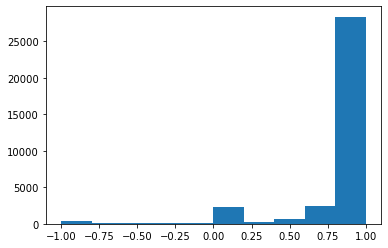

In [103]:
plt.hist(df_daily['nestboxes_related_behavior']);

In [104]:
#should be nan:
display(df_daily[df_daily['level']>dt.datetime(2021,8,15,0,0,0)]['nestboxes_related_behavior'])
#if spent less than 15minutes in total in the nestbox zone: should be 0
df_daily[df_daily['duration_4_Zone']<15*60]['nestboxes_related_behavior']

Series([], Name: nestboxes_related_behavior, dtype: float64)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
39180    0.0
39184    0.0
39187    0.0
39190    0.0
39364    0.0
Name: nestboxes_related_behavior, Length: 1788, dtype: float64

In [105]:
#ATTENTION: nestboxes_related_behavior only once the barn schedule is stable!
display(df_daily[(df_daily['nestboxes_related_behavior']<0)&(df_daily['DIB']>50)].head(2))
h = 'hen_134'
d = dt.datetime(2021,1,8) #late date to have nestbox usage
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_nb].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
display((dt.datetime(2020,11,22,5,13,10)-dt.datetime(2020,11,22,4,45,21)).total_seconds())
display((dt.datetime(2020,11,22,4,45,21)-dt.datetime(2020,11,22,4,15,21)).total_seconds())
#CORRECT!
#Note that: B10h_Nestbox_nbrvisit is the number of visits DURING DAY TIME in the test box

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,KBF_interp,FeatherDamage_interp,weight_interp,HenID_WIB,food_related_behavior_final,food_related_behavior_rp_final,food_related_behavior_rm_final,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final
239,hen_134,2021-02-19,1854.0,16071.0,5246.0,6573.0,24256.0,54000.0,15.0,"[1854.0, 16071.0, 5246.0, 6573.0, 24256.0]",...,5.6,5.504762,1724.322857,hen_134-WIB21,0.033748,-0.129209,-0.070677,0.454194,-0.321924,-0.108306
253,hen_134,2021-03-05,952.0,20168.0,8348.0,8767.0,15765.0,54000.0,15.0,"[952.0, 20168.0, 8348.0, 8767.0, 15765.0]",...,8.4,7.971429,1743.162857,hen_134-WIB23,-0.090342,-0.093772,-0.334381,-0.342035,-0.192729,-0.158729


,HenID,level,PenID,nestboxes_related_behavior,mid_cum_Z4_sec,mid_cum_Z4_sec_Morning,mid_cum_Z4_h_Morning


((Timestamp('2021-01-08 02:06:01'), '2_Zone'),
 (Timestamp('2021-01-08 02:43:01'), '3_Zone'),
 (Timestamp('2021-01-08 03:01:11'), '2_Zone'),
 (Timestamp('2021-01-08 03:24:57'), '3_Zone'),
 (Timestamp('2021-01-08 03:29:06'), '5_Zone'),
 (Timestamp('2021-01-08 03:52:53'), '2_Zone'),
 (Timestamp('2021-01-08 04:05:43'), '3_Zone'),
 (Timestamp('2021-01-08 04:11:52'), '2_Zone'),
 (Timestamp('2021-01-08 04:20:27'), '3_Zone'),
 (Timestamp('2021-01-08 04:24:04'), '5_Zone'),
 (Timestamp('2021-01-08 04:27:05'), '3_Zone'),
 (Timestamp('2021-01-08 04:29:12'), '5_Zone'),
 (Timestamp('2021-01-08 04:30:51'), '3_Zone'),
 (Timestamp('2021-01-08 05:32:45'), '2_Zone'),
 (Timestamp('2021-01-08 05:50:38'), '3_Zone'),
 (Timestamp('2021-01-08 05:57:49'), '5_Zone'),
 (Timestamp('2021-01-08 06:01:39'), '3_Zone'),
 (Timestamp('2021-01-08 06:12:08'), '5_Zone'),
 (Timestamp('2021-01-08 07:15:04'), '3_Zone'),
 (Timestamp('2021-01-08 07:18:31'), '5_Zone'),
 (Timestamp('2021-01-08 07:22:42'), '2_Zone'),
 (Timestamp('

1669.0

1800.0

In [106]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_nb]
print(len(li_var_TODO))
display(li_var_TODO)

71


['HenID',
 'level',
 'verification_daily_total_nbr_hour',
 'dur_values',
 'dur_values_normalized',
 'time_wg_open_sec',
 'duration_sincedaystarted_beforeWGopened_sec',
 'perc_1_Zone_while_WG_open',
 'nbr_h_WGopen',
 'food_related_behavior',
 'food_related_behavior_rp',
 'food_related_behavior_rm',
 'food_related_behavior4',
 'food_related_behavior_rp4',
 'food_related_behavior_rm4',
 'list_of_zones',
 'list_ZALL',
 'nbr_stays',
 'distribution_entropy',
 'nbr_stays_total',
 'PenID',
 'early_death',
 'Treatment',
 'nbr_h_per_day',
 'correct_amount_of_hour',
 'DOA',
 'WOA',
 'DIB',
 'WIB',
 'food_sameDurTiming_r50_nbrbatch',
 'food_sameDurTiming_r50',
 'food_sameDurTiming_tFZ_ALL',
 'food_sameDurTiming_tFZ_ALL_FAKE',
 'food_sameDurTiming_nbrbatch',
 'food_sameDurTiming_r50_nbrbatch_AP',
 'food_sameDurTiming_r50_AP',
 'food_sameDurTiming_tFZ_ALL_AP',
 'food_sameDurTiming_tFZ_ALL_FAKE_AP',
 'food_sameDurTiming_nbrbatch_AP',
 'food_sameDurTiming_r50_nbrbatch_AB',
 'food_sameDurTiming_r50_AB'

## WG

In [107]:
#latency should be FirstTimestamp_1_Zone_sec-duration_sincedaystarted_beforeWGopened_sec: nbr of seconds since opened
df_daily[['level','nbr_h_WGopen','FirstTimestamp_1_Zone','FirstTimestamp_1_Zone_sec','duration_sincedaystarted_beforeWGopened_sec','latency_1_Zone_h']]

,level,nbr_h_WGopen,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,duration_sincedaystarted_beforeWGopened_sec,latency_1_Zone_h
0,2020-10-05,0.000000,NaT,NaN,39600.0,NaN
1,2020-10-06,0.000000,NaT,NaN,39600.0,NaN
2,2020-10-07,0.000000,NaT,NaN,39600.0,NaN
3,2020-09-30,0.000000,NaT,NaN,39600.0,NaN
4,2020-10-01,0.000000,NaT,NaN,39600.0,NaN
...,...,...,...,...,...,...
39377,2021-07-20,6.666667,2021-07-20 10:54:59,39299.0,36000.0,0.916389
39378,2021-07-21,8.500000,2021-07-21 08:08:54,29334.0,28800.0,0.148333
39379,2021-07-22,8.333333,2021-07-22 09:17:02,33422.0,28800.0,1.283889
39380,2021-07-23,8.333333,2021-07-23 08:37:52,31072.0,28800.0,0.631111


In [108]:
#check when close: all is nan
df_daily[df_daily['nbr_h_WGopen']==0][['HenID','nbr_h_WGopen','level','FirstTimestamp_1_Zone','FirstTimestamp_1_Zone_sec','duration_sincedaystarted_beforeWGopened_sec',
                                       'latency_1_Zone_h']]

,HenID,nbr_h_WGopen,level,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,duration_sincedaystarted_beforeWGopened_sec,latency_1_Zone_h
0,hen_130,0.0,2020-10-05,NaT,NaN,39600.0,NaN
1,hen_130,0.0,2020-10-06,NaT,NaN,39600.0,NaN
2,hen_130,0.0,2020-10-07,NaT,NaN,39600.0,NaN
3,hen_131,0.0,2020-09-30,NaT,NaN,39600.0,NaN
4,hen_131,0.0,2020-10-01,NaT,NaN,39600.0,NaN
...,...,...,...,...,...,...,...
39223,hen_98,0.0,2021-01-12,NaT,NaN,36000.0,NaN
39246,hen_98,0.0,2021-02-13,NaT,NaN,38400.0,NaN
39247,hen_98,0.0,2021-02-14,NaT,NaN,38400.0,NaN
39250,hen_98,0.0,2021-02-17,NaT,NaN,36000.0,NaN


In [109]:
#latency for birds never going outside
df_daily[(df_daily['level']>dt.datetime(2021,2,2))&(df_daily['FirstTimestamp_1_Zone'].isnull())][['level','FirstTimestamp_1_Zone','FirstTimestamp_1_Zone_sec','duration_sincedaystarted_beforeWGopened_sec','latency_1_Zone_h']]

,level,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,duration_sincedaystarted_beforeWGopened_sec,latency_1_Zone_h
232,2021-02-12,NaT,NaN,43200.0,1.500000
233,2021-02-13,NaT,NaN,38400.0,NaN
234,2021-02-14,NaT,NaN,38400.0,NaN
237,2021-02-17,NaT,NaN,36000.0,NaN
256,2021-03-08,NaT,NaN,36000.0,6.500000
...,...,...,...,...,...
39247,2021-02-14,NaT,NaN,38400.0,NaN
39250,2021-02-17,NaT,NaN,36000.0,NaN
39266,2021-03-06,NaT,NaN,36000.0,6.833333
39286,2021-03-26,NaT,NaN,48600.0,3.000000


In [110]:
li_wg = [i for i in li_var_TODO if 'WG' in i]+[i for i in df_daily.columns if '1_Zone' in i]+['duration_1_Zone']
li_wg
#'in_WG_15mnAfterOpening', 'Max_duration_WG', latency1_zone, perc_1_Zone_while_WG_open

['duration_sincedaystarted_beforeWGopened_sec',
 'perc_1_Zone_while_WG_open',
 'nbr_h_WGopen',
 'duration_1_Zone',
 'perc_duration_1_Zone',
 'perc_1_Zone_while_WG_open',
 'FirstTimestamp_1_Zone',
 'FirstTimestamp_1_Zone_sec',
 'latency_1_Zone_h',
 'nbr_stays_1_Zone',
 'duration_1_Zone']

In [111]:
#should nly be nan as WG not opened
print(config.date_first_opening_WG)
df_daily[df_daily['level']<config.date_first_opening_WG][['HenID','level']+li_wg]

2020-10-08 00:00:00


,HenID,level,duration_sincedaystarted_beforeWGopened_sec,perc_1_Zone_while_WG_open,nbr_h_WGopen,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,duration_1_Zone
0,hen_130,2020-10-05,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,hen_130,2020-10-06,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,hen_130,2020-10-07,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,hen_131,2020-09-30,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,hen_131,2020-10-01,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39128,hen_98,2020-09-30,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
39129,hen_98,2020-10-01,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
39130,hen_98,2020-10-02,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
39131,hen_98,2020-10-06,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


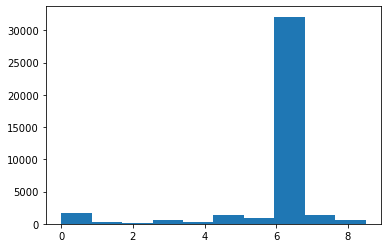

In [112]:
plt.hist(df_daily['nbr_h_WGopen']);

In [113]:
df_daily[df_daily['nbr_h_WGopen']<3][['level','nbr_h_WGopen','latency_1_Zone_h']]

,level,nbr_h_WGopen,latency_1_Zone_h
0,2020-10-05,0.0,NaN
1,2020-10-06,0.0,NaN
2,2020-10-07,0.0,NaN
3,2020-09-30,0.0,NaN
4,2020-10-01,0.0,NaN
...,...,...,...
39245,2021-02-12,1.5,1.130278
39246,2021-02-13,0.0,NaN
39247,2021-02-14,0.0,NaN
39250,2021-02-17,0.0,NaN


In [114]:
df_daily[df_daily['level']>=config.date_first_opening_WG][['HenID','level','is_mvt_night']+li_wg].tail(5)

,HenID,level,is_mvt_night,duration_sincedaystarted_beforeWGopened_sec,perc_1_Zone_while_WG_open,nbr_h_WGopen,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,duration_1_Zone
39377,hen_98,2021-07-20,1.0,36000.0,27.870833,6.666667,6689.0,12.0,27.870833,2021-07-20 10:54:59,39299.0,0.916389,15.0,6689.0
39378,hen_98,2021-07-21,1.0,28800.0,12.209150,8.500000,3736.0,7.0,12.209150,2021-07-21 08:08:54,29334.0,0.148333,12.0,3736.0
39379,hen_98,2021-07-22,1.0,28800.0,26.423333,8.333333,7927.0,15.0,26.423333,2021-07-22 09:17:02,33422.0,1.283889,13.0,7927.0
39380,hen_98,2021-07-23,0.0,28800.0,32.143333,8.333333,9643.0,18.0,32.143333,2021-07-23 08:37:52,31072.0,0.631111,21.0,9643.0
39381,hen_98,2021-07-24,0.0,28800.0,30.066667,8.333333,9020.0,17.0,30.066667,2021-07-24 08:10:45,29445.0,0.179167,22.0,9020.0


In [115]:
#bird based on : df_daily[df_daily['Max_duration_WG']>0].tail(15)
h = 'hen_98'
d = dt.datetime(2021,1,10)  #10h a 16h20(to be checked with new data)
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_wg].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct

,HenID,level,PenID,duration_sincedaystarted_beforeWGopened_sec,perc_1_Zone_while_WG_open,nbr_h_WGopen,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,duration_1_Zone
39221,hen_98,2021-01-10,9,36000.0,0.270833,6.666667,65.0,0.0,0.270833,2021-01-10 12:59:40,46780.0,2.994444,1.0,65.0


((Timestamp('2021-01-10 06:26:34'), '4_Zone'),
 (Timestamp('2021-01-10 08:55:57'), '3_Zone'),
 (Timestamp('2021-01-10 08:56:20'), '2_Zone'),
 (Timestamp('2021-01-10 09:15:07'), '3_Zone'),
 (Timestamp('2021-01-10 09:33:12'), '4_Zone'),
 (Timestamp('2021-01-10 09:33:43'), '5_Zone'),
 (Timestamp('2021-01-10 09:34:41'), '4_Zone'),
 (Timestamp('2021-01-10 09:34:58'), '3_Zone'),
 (Timestamp('2021-01-10 09:35:05'), '2_Zone'),
 (Timestamp('2021-01-10 09:49:14'), '3_Zone'),
 (Timestamp('2021-01-10 10:12:51'), '4_Zone'),
 (Timestamp('2021-01-10 10:14:11'), '5_Zone'),
 (Timestamp('2021-01-10 12:45:55'), '4_Zone'),
 (Timestamp('2021-01-10 12:46:06'), '3_Zone'),
 (Timestamp('2021-01-10 12:46:08'), '2_Zone'),
 (Timestamp('2021-01-10 12:59:40'), '1_Zone'),
 (Timestamp('2021-01-10 13:00:45'), '2_Zone'),
 (Timestamp('2021-01-10 13:09:21'), '3_Zone'),
 (Timestamp('2021-01-10 13:24:26'), '2_Zone'),
 (Timestamp('2021-01-10 14:01:36'), '3_Zone'),
 (Timestamp('2021-01-10 14:03:43'), '4_Zone'),
 (Timestamp('

In [116]:
#random bird
h = 'hen_12'
d = dt.datetime(2021,1,9)  #10h a 16h20(to be checked with new data)
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_wg].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
display(dt.datetime(2021,1,15,9,14)-dt.datetime(2021,1,15,8,58),
       dt.datetime(2021,1,15,10,55)-dt.datetime(2021,1,15,9,23))
#Correct

,HenID,level,PenID,duration_sincedaystarted_beforeWGopened_sec,perc_1_Zone_while_WG_open,nbr_h_WGopen,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,duration_1_Zone
25775,hen_12,2021-01-09,5,36000.0,0.393162,6.5,92.0,0.0,0.393162,2021-01-09 15:09:23,54563.0,5.156389,1.0,92.0


((Timestamp('2021-01-09 03:44:18'), '4_Zone'),
 (Timestamp('2021-01-09 04:45:58'), '3_Zone'),
 (Timestamp('2021-01-09 05:17:19'), '2_Zone'),
 (Timestamp('2021-01-09 05:27:22'), '3_Zone'),
 (Timestamp('2021-01-09 05:56:31'), '2_Zone'),
 (Timestamp('2021-01-09 06:04:43'), '3_Zone'),
 (Timestamp('2021-01-09 06:11:59'), '4_Zone'),
 (Timestamp('2021-01-09 06:12:13'), '5_Zone'),
 (Timestamp('2021-01-09 09:47:05'), '4_Zone'),
 (Timestamp('2021-01-09 09:47:22'), '3_Zone'),
 (Timestamp('2021-01-09 09:47:37'), '2_Zone'),
 (Timestamp('2021-01-09 10:15:32'), '3_Zone'),
 (Timestamp('2021-01-09 10:15:56'), '4_Zone'),
 (Timestamp('2021-01-09 10:17:24'), '5_Zone'),
 (Timestamp('2021-01-09 14:51:38'), '4_Zone'),
 (Timestamp('2021-01-09 14:51:54'), '3_Zone'),
 (Timestamp('2021-01-09 14:52:03'), '2_Zone'),
 (Timestamp('2021-01-09 15:09:23'), '1_Zone'),
 (Timestamp('2021-01-09 15:10:55'), '2_Zone'),
 (Timestamp('2021-01-09 15:23:51'), '3_Zone'),
 (Timestamp('2021-01-09 15:32:18'), '4_Zone'),
 (Timestamp('

datetime.timedelta(seconds=960)

datetime.timedelta(seconds=5520)

In [117]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_wg]
print(len(li_var_TODO))
display(li_var_TODO)

68


['HenID',
 'level',
 'verification_daily_total_nbr_hour',
 'dur_values',
 'dur_values_normalized',
 'time_wg_open_sec',
 'food_related_behavior',
 'food_related_behavior_rp',
 'food_related_behavior_rm',
 'food_related_behavior4',
 'food_related_behavior_rp4',
 'food_related_behavior_rm4',
 'list_of_zones',
 'list_ZALL',
 'nbr_stays',
 'distribution_entropy',
 'nbr_stays_total',
 'PenID',
 'early_death',
 'Treatment',
 'nbr_h_per_day',
 'correct_amount_of_hour',
 'DOA',
 'WOA',
 'DIB',
 'WIB',
 'food_sameDurTiming_r50_nbrbatch',
 'food_sameDurTiming_r50',
 'food_sameDurTiming_tFZ_ALL',
 'food_sameDurTiming_tFZ_ALL_FAKE',
 'food_sameDurTiming_nbrbatch',
 'food_sameDurTiming_r50_nbrbatch_AP',
 'food_sameDurTiming_r50_AP',
 'food_sameDurTiming_tFZ_ALL_AP',
 'food_sameDurTiming_tFZ_ALL_FAKE_AP',
 'food_sameDurTiming_nbrbatch_AP',
 'food_sameDurTiming_r50_nbrbatch_AB',
 'food_sameDurTiming_r50_AB',
 'food_sameDurTiming_tFZ_ALL_AB',
 'food_sameDurTiming_tFZ_ALL_FAKE_AB',
 'food_sameDurTiming

# entropy

In [118]:
df_daily[['distribution_entropy','list_of_zones','dur_values_normalized','dur_values']]

,distribution_entropy,list_of_zones,dur_values_normalized,dur_values
0,0.000000,['5_Zone'],"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 32400.0]"
1,0.244385,"['5_Zone', '3_Zone', '4_Zone', '5_Zone']","[0.0, 0.0, 0.024074074074074074, 0.01003086419...","[0.0, 0.0, 780.0, 325.0, 31295.0]"
2,0.158130,"['3_Zone', '2_Zone', '3_Zone', '4_Zone', '5_Zo...","[0.0, 0.006358024691358025, 0.0076851851851851...","[0.0, 206.0, 249.0, 130.0, 31815.0]"
3,0.618034,"['3_Zone', '2_Zone', '3_Zone', '2_Zone', '3_Zo...","[0.0, 0.8467013888888889, 0.15329861111111112,...","[0.0, 24385.0, 4415.0, 0.0, 0.0]"
4,1.183695,"['2_Zone', '3_Zone', '2_Zone', '3_Zone', '5_Zo...","[0.0, 0.6947839506172839, 0.18351851851851853,...","[0.0, 22511.0, 5946.0, 0.0, 3943.0]"
...,...,...,...,...
39377,2.028606,"['4_Zone', '3_Zone', '4_Zone', '3_Zone', '2_Zo...","[0.12387037037037037, 0.4517777777777778, 0.07...","[6689.0, 24396.0, 4175.0, 6437.0, 12303.0]"
39378,1.793944,"['3_Zone', '4_Zone', '3_Zone', '2_Zone', '3_Zo...","[0.06918518518518518, 0.5641481481481482, 0.10...","[3736.0, 30464.0, 5678.0, 3584.0, 10538.0]"
39379,2.037801,"['4_Zone', '3_Zone', '4_Zone', '3_Zone', '2_Zo...","[0.14679629629629629, 0.44862962962962966, 0.1...","[7927.0, 24226.0, 5714.0, 4269.0, 11864.0]"
39380,2.117442,"['4_Zone', '3_Zone', '2_Zone', '3_Zone', '2_Zo...","[0.17857407407407408, 0.42227777777777775, 0.1...","[9643.0, 22803.0, 6564.0, 5669.0, 9321.0]"


In [119]:
from scipy.stats import entropy
#Note: order does not matter, number of 0min in a zone does not matter
print(entropy([0.0, 0.0, 780.0, 325.0, 31295.0], base=2),
entropy([0.0, 206.0, 249.0, 130.0, 31815.0,0,0,0,0], base=2),
entropy([0.0, 206.0, 249.0, 130.0, 31815.0], base=2),
entropy([1/6, 1/6, 1/6, 1/6, 1/6, 1/6], base=2),
entropy([1/5, 1/5, 1/5, 1/5, 1/5], base=2),
entropy([1/4, 1/4, 1/4, 1/4], base=2))

0.24438458187120013 0.15812999407546002 0.15812999407546005 2.584962500721156 2.3219280948873626 2.0


In [120]:
#max entropy with 5 zones
nbr_zone = 5
print(math.log(nbr_zone, 2), entropy([1,1,1,1,1],base=2))
if round(math.log(nbr_zone, 2),8)!=round(entropy([1,1,1,1,1],base=2),8):
    print('ERROR 1')
    sys.exit()
if df_daily['distribution_entropy'].max()>math.log(nbr_zone, 2):
    print('ERROR 2')
    sys.exit()

2.321928094887362 2.3219280948873626


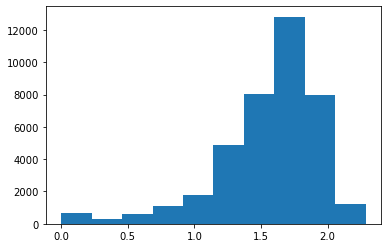

In [121]:
plt.hist(df_daily['distribution_entropy']);

## Other

In [122]:
df_daily['verification_daily_total_duration'].value_counts()

54000.0    33531
43200.0     1249
46800.0     1077
50400.0     1016
39600.0      928
32400.0      814
36000.0      624
28800.0      143
Name: verification_daily_total_duration, dtype: int64

In [123]:
df_daily[df_daily['verification_daily_total_duration']==28800]['level'].value_counts() #on the 30 septemebr: 9h-17h was the 
#light on: 8h=28'800
#2020-09-30: first full day, but for the chicken that never moved since they enter the day before, they still hav no data
#Correct!

2020-09-30    143
Name: level, dtype: int64

In [124]:
display(df_daily[df_daily['verification_daily_total_duration']<28800]['HenID'].value_counts())
df_daily[df_daily['verification_daily_total_duration']<28800]['level'].value_counts()
#2020-09-30: first full day, but for the chicken that never moved since they enter the day before, they still hav no data

Series([], Name: HenID, dtype: int64)

Series([], Name: level, dtype: int64)

In [125]:
df_daily[df_daily['verification_daily_total_duration']<28800][li_general+['verification_daily_total_duration']+\
                                                               li_first_timestamp]
#can appear in any zone... we dont know from when on, where th ebird was before going there, so we can only remove those days
#for those specific chickens
#TODO at the end of experiment: CHECK ALL CASES ONE BY ONE

,HenID,level,PenID,verification_daily_total_duration,FirstTimestamp_1_Zone,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone


# Save and last verification

In [126]:
li_dur = ['duration_1_Zone','duration_2_Zone','duration_3_Zone','duration_4_Zone','duration_5_Zone']
for x in li_dur:
    df_daily[x+'_min'] = df_daily[x].map(lambda x: x/60)

In [127]:
#to control for
df_daily['Has_been_toptier_wholeday'] = df_daily['perc_duration_5_Zone'].map(lambda x: x==100)
df_daily['Has_been_toptier_wholeday'].value_counts()

False    38892
True       490
Name: Has_been_toptier_wholeday, dtype: int64

In [128]:
df_daily['PenID'] = df_daily['PenID'].map(lambda x: 'pen'+str(x))
df_daily['PenID'].unique()

array(['pen10', 'pen11', 'pen12', 'pen3', 'pen4', 'pen5', 'pen8', 'pen9'],
      dtype=object)

In [129]:
dico_d_week = {0:'monday',
               1:'tuesday',
               2:'wednesday',
               3:'thursday',
               4:'friday',
               5:'saturday',
               6:'sunday'}
df_daily['weekday'] = df_daily['level'].map(lambda x : dico_d_week[x.weekday()]) #monday=0,...
df_daily[df_daily['weekday']=='sunday']['level'].max() #check manually: correct

Timestamp('2021-07-18 00:00:00')

In [130]:
df_daily[['HenID_WIB','HenID','KBF_interp','FeatherDamage_interp','weight_interp',
          'latency_1_Zone_h','nbr_h_WGopen',
          'mid_cum_Z4_h_Morning',
          'Sleeping_NotUppest','Has_been_toptier_wholeday', 
          'vertical_travel_distance_fulllight_perinsideh',
          'food_related_behavior_final', 'food_related_behavior_rp_final','food_related_behavior_rm_final']].tail(5)

,HenID_WIB,HenID,KBF_interp,FeatherDamage_interp,weight_interp,latency_1_Zone_h,nbr_h_WGopen,mid_cum_Z4_h_Morning,Sleeping_NotUppest,Has_been_toptier_wholeday,vertical_travel_distance_fulllight_perinsideh,food_related_behavior_final,food_related_behavior_rp_final,food_related_behavior_rm_final
39377,hen_98-WIB42,hen_98,31.230769,40.144231,1754.930769,0.916389,6.666667,6.138333,1,False,5.570480,0.009819,-0.109811,-0.352682
39378,hen_98-WIB43,hen_98,31.384615,40.448718,1755.084615,0.148333,8.500000,5.682222,1,False,4.728801,0.440509,0.131816,-0.154481
39379,hen_98-WIB43,hen_98,31.538462,40.753205,1755.238462,1.283889,8.333333,5.726944,1,False,5.881704,0.193566,-0.439270,-0.124853
39380,hen_98-WIB43,hen_98,31.692308,41.057692,1755.392308,0.631111,8.333333,5.677778,1,False,5.948092,0.097631,0.089819,-0.566037
39381,hen_98-WIB43,hen_98,31.846154,41.362179,1755.546154,0.179167,8.333333,6.150278,1,False,5.375566,-0.150950,-0.279975,0.064828


In [131]:
df_daily_ = df_daily.drop(['list_of_zones','dur_values_normalized','list_ZALL','food_sameDurTiming_r50_nbrbatch']+li_dur,axis=1)
df_daily_.to_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'),sep=';',index=False)
print(df_daily_.shape)
df_daily_.head(3)

(39382, 115)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,weekday
0,hen_130,2020-10-05,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",0.0,0.0,100.0,0.0,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.00,0.000000,540.000000,True,monday
1,hen_130,2020-10-06,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",2.0,1.0,97.0,0.0,NaN,...,NaN,NaN,NaN,NaN,0.000000,13.00,5.416667,521.583333,False,tuesday
2,hen_130,2020-10-07,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",1.0,0.0,98.0,1.0,NaN,...,NaN,NaN,NaN,NaN,3.433333,4.15,2.166667,530.250000,False,wednesday


In [132]:
df_daily['time_wg_open_sec']

0        21600.0
1        21600.0
2        21600.0
3        21600.0
4        21600.0
          ...   
39377    24000.0
39378    30600.0
39379    30000.0
39380    30000.0
39381    30000.0
Name: time_wg_open_sec, Length: 39382, dtype: float64